In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 10000
lstm_hidden_size = 64
epochs = 20
experiment_id = (
    "classification-max_training_samples-10000-lstm_hidden_size-64-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


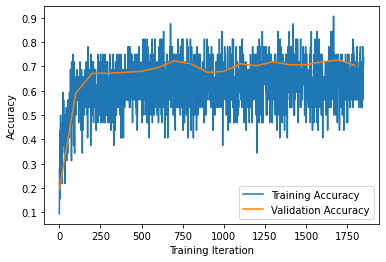

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.160 Validation Loss: 2.158 Accuracy: 0.445 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.159 Validation Loss: 2.158 Accuracy: 0.418 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.162 Validation Loss: 2.158 Accuracy: 0.411 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.164 Validation Loss: 2.158 Accuracy: 0.393 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.162 Validation Loss: 2.158 Accuracy: 0.389 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.160 Validation Loss: 2.158 Accuracy: 0.396 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.161 Validation Loss: 2.158 Accuracy: 0.394 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.160 Validation Loss: 2.158 Accuracy: 0.404 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.160 Validation Loss: 2.158 Accuracy: 0.405 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.158 Validation Loss: 2.158 Accuracy: 0.411 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.157 Validation Loss: 2.158 Accuracy: 0.412 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.157 Validation Loss: 2.158 Accuracy: 0.418 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.157 Validation Loss: 2.158 Accuracy: 0.416 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.156 Validation Loss: 2.158 Accuracy: 0.430 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.156 Validation Loss: 2.158 Accuracy: 0.432 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.154 Validation Loss: 2.158 Accuracy: 0.445 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.154 Validation Loss: 2.158 Accuracy: 0.452 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.153 Validation Loss: 2.158 Accuracy: 0.453 Validation Accuracy: 0.434:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.153 Validation Loss: 2.158 Accuracy: 0.453 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 18 Loss: 2.152 Validation Loss: 2.158 Accuracy: 0.466 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 19 Loss: 2.153 Validation Loss: 2.158 Accuracy: 0.460 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 20 Loss: 2.152 Validation Loss: 2.158 Accuracy: 0.460 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 21 Loss: 2.151 Validation Loss: 2.158 Accuracy: 0.464 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 22 Loss: 2.149 Validation Loss: 2.158 Accuracy: 0.474 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 23 Loss: 2.148 Validation Loss: 2.158 Accuracy: 0.481 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 24 Loss: 2.147 Validation Loss: 2.158 Accuracy: 0.489 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 25 Loss: 2.146 Validation Loss: 2.158 Accuracy: 0.480 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 26 Loss: 2.145 Validation Loss: 2.158 Accuracy: 0.484 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 27 Loss: 2.143 Validation Loss: 2.158 Accuracy: 0.495 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 28 Loss: 2.143 Validation Loss: 2.158 Accuracy: 0.479 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 29 Loss: 2.142 Validation Loss: 2.158 Accuracy: 0.487 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 30 Loss: 2.142 Validation Loss: 2.158 Accuracy: 0.488 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 31 Loss: 2.141 Validation Loss: 2.158 Accuracy: 0.488 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 32 Loss: 2.138 Validation Loss: 2.158 Accuracy: 0.496 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 33 Loss: 2.137 Validation Loss: 2.158 Accuracy: 0.498 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 34 Loss: 2.137 Validation Loss: 2.158 Accuracy: 0.495 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 35 Loss: 2.138 Validation Loss: 2.158 Accuracy: 0.494 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 36 Loss: 2.137 Validation Loss: 2.158 Accuracy: 0.490 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

(10000, 10, 769)


Epoch: 0 Iteration: 37 Loss: 2.136 Validation Loss: 2.158 Accuracy: 0.485 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 38 Loss: 2.135 Validation Loss: 2.158 Accuracy: 0.499 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 39 Loss: 2.133 Validation Loss: 2.158 Accuracy: 0.502 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 40 Loss: 2.132 Validation Loss: 2.158 Accuracy: 0.505 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 41 Loss: 2.132 Validation Loss: 2.158 Accuracy: 0.508 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 42 Loss: 2.131 Validation Loss: 2.158 Accuracy: 0.507 Validation Accuracy: 0.434:  23%|██▎       | 18/79 [00:00<00:00, 179.47it/s]

Epoch: 0 Iteration: 42 Loss: 2.131 Validation Loss: 2.158 Accuracy: 0.507 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 43 Loss: 2.131 Validation Loss: 2.158 Accuracy: 0.496 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 44 Loss: 2.129 Validation Loss: 2.158 Accuracy: 0.506 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 45 Loss: 2.129 Validation Loss: 2.158 Accuracy: 0.512 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 46 Loss: 2.128 Validation Loss: 2.158 Accuracy: 0.516 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 47 Loss: 2.128 Validation Loss: 2.158 Accuracy: 0.506 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 48 Loss: 2.128 Validation Loss: 2.158 Accuracy: 0.501 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 49 Loss: 2.127 Validation Loss: 2.158 Accuracy: 0.495 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 50 Loss: 2.126 Validation Loss: 2.158 Accuracy: 0.495 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 51 Loss: 2.125 Validation Loss: 2.158 Accuracy: 0.493 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 52 Loss: 2.126 Validation Loss: 2.158 Accuracy: 0.485 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 53 Loss: 2.126 Validation Loss: 2.158 Accuracy: 0.487 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 54 Loss: 2.124 Validation Loss: 2.158 Accuracy: 0.480 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 55 Loss: 2.124 Validation Loss: 2.158 Accuracy: 0.482 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 56 Loss: 2.122 Validation Loss: 2.158 Accuracy: 0.488 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 57 Loss: 2.120 Validation Loss: 2.158 Accuracy: 0.500 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 58 Loss: 2.119 Validation Loss: 2.158 Accuracy: 0.507 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 59 Loss: 2.119 Validation Loss: 2.158 Accuracy: 0.506 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 60 Loss: 2.118 Validation Loss: 2.158 Accuracy: 0.505 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 61 Loss: 2.118 Validation Loss: 2.158 Accuracy: 0.507 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 62 Loss: 2.117 Validation Loss: 2.158 Accuracy: 0.514 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 63 Loss: 2.115 Validation Loss: 2.158 Accuracy: 0.517 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 64 Loss: 2.115 Validation Loss: 2.158 Accuracy: 0.517 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 65 Loss: 2.114 Validation Loss: 2.158 Accuracy: 0.513 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 66 Loss: 2.112 Validation Loss: 2.158 Accuracy: 0.516 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 67 Loss: 2.111 Validation Loss: 2.158 Accuracy: 0.509 Validation Accuracy: 0.434:  54%|█████▍    | 43/79 [00:00<00:00, 218.36it/s]

Epoch: 0 Iteration: 67 Loss: 2.111 Validation Loss: 2.158 Accuracy: 0.509 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 68 Loss: 2.110 Validation Loss: 2.158 Accuracy: 0.501 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 69 Loss: 2.108 Validation Loss: 2.158 Accuracy: 0.512 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 70 Loss: 2.109 Validation Loss: 2.158 Accuracy: 0.505 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 71 Loss: 2.108 Validation Loss: 2.158 Accuracy: 0.505 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 72 Loss: 2.106 Validation Loss: 2.158 Accuracy: 0.502 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 73 Loss: 2.105 Validation Loss: 2.158 Accuracy: 0.500 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 74 Loss: 2.105 Validation Loss: 2.158 Accuracy: 0.501 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 75 Loss: 2.103 Validation Loss: 2.158 Accuracy: 0.500 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 76 Loss: 2.103 Validation Loss: 2.158 Accuracy: 0.492 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 77 Loss: 2.104 Validation Loss: 2.158 Accuracy: 0.488 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 78 Loss: 2.102 Validation Loss: 2.158 Accuracy: 0.491 Validation Accuracy: 0.434:  86%|████████▌ | 68/79 [00:00<00:00, 230.04it/s]

Epoch: 0 Iteration: 78 Loss: 2.102 Validation Loss: 2.158 Accuracy: 0.491 Validation Accuracy: 0.434: 100%|██████████| 79/79 [00:00<00:00, 226.45it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.102 Validation Loss: 2.094 Accuracy: 0.478 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.102 Validation Loss: 2.094 Accuracy: 0.478 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.100 Validation Loss: 2.094 Accuracy: 0.478 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.100 Validation Loss: 2.094 Accuracy: 0.477 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.100 Validation Loss: 2.094 Accuracy: 0.484 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.099 Validation Loss: 2.094 Accuracy: 0.484 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.098 Validation Loss: 2.094 Accuracy: 0.487 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.099 Validation Loss: 2.094 Accuracy: 0.482 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.098 Validation Loss: 2.094 Accuracy: 0.486 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.096 Validation Loss: 2.094 Accuracy: 0.483 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.096 Validation Loss: 2.094 Accuracy: 0.491 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.094 Validation Loss: 2.094 Accuracy: 0.504 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.092 Validation Loss: 2.094 Accuracy: 0.512 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.091 Validation Loss: 2.094 Accuracy: 0.515 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.089 Validation Loss: 2.094 Accuracy: 0.516 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.087 Validation Loss: 2.094 Accuracy: 0.520 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.086 Validation Loss: 2.094 Accuracy: 0.520 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.085 Validation Loss: 2.094 Accuracy: 0.530 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.085 Validation Loss: 2.094 Accuracy: 0.532 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.086 Validation Loss: 2.094 Accuracy: 0.534 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 2.083 Validation Loss: 2.094 Accuracy: 0.540 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 2.082 Validation Loss: 2.094 Accuracy: 0.533 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 2.082 Validation Loss: 2.094 Accuracy: 0.526 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 2.080 Validation Loss: 2.094 Accuracy: 0.528 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.080 Validation Loss: 2.094 Accuracy: 0.520 Validation Accuracy: 0.482:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.080 Validation Loss: 2.094 Accuracy: 0.520 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 25 Loss: 2.079 Validation Loss: 2.094 Accuracy: 0.515 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 26 Loss: 2.079 Validation Loss: 2.094 Accuracy: 0.512 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 27 Loss: 2.078 Validation Loss: 2.094 Accuracy: 0.513 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 28 Loss: 2.076 Validation Loss: 2.094 Accuracy: 0.515 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 29 Loss: 2.075 Validation Loss: 2.094 Accuracy: 0.530 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 30 Loss: 2.074 Validation Loss: 2.094 Accuracy: 0.525 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 31 Loss: 2.074 Validation Loss: 2.094 Accuracy: 0.528 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 32 Loss: 2.074 Validation Loss: 2.094 Accuracy: 0.523 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 33 Loss: 2.074 Validation Loss: 2.094 Accuracy: 0.520 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 34 Loss: 2.072 Validation Loss: 2.094 Accuracy: 0.527 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 35 Loss: 2.073 Validation Loss: 2.094 Accuracy: 0.534 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 36 Loss: 2.072 Validation Loss: 2.094 Accuracy: 0.534 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 37 Loss: 2.074 Validation Loss: 2.094 Accuracy: 0.529 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 38 Loss: 2.071 Validation Loss: 2.094 Accuracy: 0.530 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 39 Loss: 2.069 Validation Loss: 2.094 Accuracy: 0.519 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 40 Loss: 2.070 Validation Loss: 2.094 Accuracy: 0.523 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 41 Loss: 2.068 Validation Loss: 2.094 Accuracy: 0.521 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 42 Loss: 2.068 Validation Loss: 2.094 Accuracy: 0.524 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 43 Loss: 2.068 Validation Loss: 2.094 Accuracy: 0.526 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 44 Loss: 2.065 Validation Loss: 2.094 Accuracy: 0.527 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 45 Loss: 2.065 Validation Loss: 2.094 Accuracy: 0.530 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 46 Loss: 2.062 Validation Loss: 2.094 Accuracy: 0.540 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 47 Loss: 2.062 Validation Loss: 2.094 Accuracy: 0.543 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 48 Loss: 2.062 Validation Loss: 2.094 Accuracy: 0.538 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 49 Loss: 2.063 Validation Loss: 2.094 Accuracy: 0.537 Validation Accuracy: 0.482:  32%|███▏      | 25/79 [00:00<00:00, 241.51it/s]

Epoch: 1 Iteration: 49 Loss: 2.063 Validation Loss: 2.094 Accuracy: 0.537 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 50 Loss: 2.059 Validation Loss: 2.094 Accuracy: 0.543 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 51 Loss: 2.058 Validation Loss: 2.094 Accuracy: 0.546 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 52 Loss: 2.057 Validation Loss: 2.094 Accuracy: 0.549 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 53 Loss: 2.057 Validation Loss: 2.094 Accuracy: 0.543 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 54 Loss: 2.057 Validation Loss: 2.094 Accuracy: 0.545 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 55 Loss: 2.057 Validation Loss: 2.094 Accuracy: 0.543 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 56 Loss: 2.055 Validation Loss: 2.094 Accuracy: 0.542 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 57 Loss: 2.053 Validation Loss: 2.094 Accuracy: 0.547 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 58 Loss: 2.052 Validation Loss: 2.094 Accuracy: 0.555 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 59 Loss: 2.051 Validation Loss: 2.094 Accuracy: 0.552 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 60 Loss: 2.050 Validation Loss: 2.094 Accuracy: 0.549 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 61 Loss: 2.049 Validation Loss: 2.094 Accuracy: 0.542 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 62 Loss: 2.047 Validation Loss: 2.094 Accuracy: 0.544 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 63 Loss: 2.047 Validation Loss: 2.094 Accuracy: 0.557 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 64 Loss: 2.047 Validation Loss: 2.094 Accuracy: 0.546 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 65 Loss: 2.045 Validation Loss: 2.094 Accuracy: 0.547 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 66 Loss: 2.047 Validation Loss: 2.094 Accuracy: 0.539 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 67 Loss: 2.047 Validation Loss: 2.094 Accuracy: 0.534 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 68 Loss: 2.044 Validation Loss: 2.094 Accuracy: 0.539 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 69 Loss: 2.043 Validation Loss: 2.094 Accuracy: 0.544 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 70 Loss: 2.044 Validation Loss: 2.094 Accuracy: 0.537 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 71 Loss: 2.043 Validation Loss: 2.094 Accuracy: 0.551 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 72 Loss: 2.040 Validation Loss: 2.094 Accuracy: 0.552 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 73 Loss: 2.039 Validation Loss: 2.094 Accuracy: 0.543 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 74 Loss: 2.038 Validation Loss: 2.094 Accuracy: 0.551 Validation Accuracy: 0.482:  63%|██████▎   | 50/79 [00:00<00:00, 243.27it/s]

Epoch: 1 Iteration: 74 Loss: 2.038 Validation Loss: 2.094 Accuracy: 0.551 Validation Accuracy: 0.482:  95%|█████████▍| 75/79 [00:00<00:00, 244.96it/s]

Epoch: 1 Iteration: 75 Loss: 2.037 Validation Loss: 2.094 Accuracy: 0.548 Validation Accuracy: 0.482:  95%|█████████▍| 75/79 [00:00<00:00, 244.96it/s]

Epoch: 1 Iteration: 76 Loss: 2.037 Validation Loss: 2.094 Accuracy: 0.555 Validation Accuracy: 0.482:  95%|█████████▍| 75/79 [00:00<00:00, 244.96it/s]

Epoch: 1 Iteration: 77 Loss: 2.036 Validation Loss: 2.094 Accuracy: 0.562 Validation Accuracy: 0.482:  95%|█████████▍| 75/79 [00:00<00:00, 244.96it/s]

Epoch: 1 Iteration: 78 Loss: 2.037 Validation Loss: 2.094 Accuracy: 0.557 Validation Accuracy: 0.482:  95%|█████████▍| 75/79 [00:00<00:00, 244.96it/s]

Epoch: 1 Iteration: 78 Loss: 2.037 Validation Loss: 2.094 Accuracy: 0.557 Validation Accuracy: 0.482: 100%|██████████| 79/79 [00:00<00:00, 245.66it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 2.037 Validation Loss: 2.032 Accuracy: 0.553 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 2.037 Validation Loss: 2.032 Accuracy: 0.553 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 2.035 Validation Loss: 2.032 Accuracy: 0.548 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 2.035 Validation Loss: 2.032 Accuracy: 0.539 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 2.033 Validation Loss: 2.032 Accuracy: 0.541 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 2.034 Validation Loss: 2.032 Accuracy: 0.534 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 2.032 Validation Loss: 2.032 Accuracy: 0.537 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 2.028 Validation Loss: 2.032 Accuracy: 0.540 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 2.025 Validation Loss: 2.032 Accuracy: 0.540 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 2.025 Validation Loss: 2.032 Accuracy: 0.538 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 2.025 Validation Loss: 2.032 Accuracy: 0.546 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 2.026 Validation Loss: 2.032 Accuracy: 0.552 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 2.027 Validation Loss: 2.032 Accuracy: 0.551 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 2.028 Validation Loss: 2.032 Accuracy: 0.563 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 2.027 Validation Loss: 2.032 Accuracy: 0.559 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 2.028 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 2.028 Validation Loss: 2.032 Accuracy: 0.558 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 2.028 Validation Loss: 2.032 Accuracy: 0.552 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 2.027 Validation Loss: 2.032 Accuracy: 0.548 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 2.026 Validation Loss: 2.032 Accuracy: 0.547 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 2.024 Validation Loss: 2.032 Accuracy: 0.544 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 2.021 Validation Loss: 2.032 Accuracy: 0.545 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 22 Loss: 2.020 Validation Loss: 2.032 Accuracy: 0.548 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 2.020 Validation Loss: 2.032 Accuracy: 0.545 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 2.020 Validation Loss: 2.032 Accuracy: 0.556 Validation Accuracy: 0.513:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 2.020 Validation Loss: 2.032 Accuracy: 0.556 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 25 Loss: 2.018 Validation Loss: 2.032 Accuracy: 0.558 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 26 Loss: 2.019 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 27 Loss: 2.021 Validation Loss: 2.032 Accuracy: 0.566 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 28 Loss: 2.022 Validation Loss: 2.032 Accuracy: 0.558 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 29 Loss: 2.021 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 30 Loss: 2.020 Validation Loss: 2.032 Accuracy: 0.563 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 31 Loss: 2.016 Validation Loss: 2.032 Accuracy: 0.566 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 32 Loss: 2.016 Validation Loss: 2.032 Accuracy: 0.569 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 33 Loss: 2.015 Validation Loss: 2.032 Accuracy: 0.569 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 34 Loss: 2.013 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 35 Loss: 2.010 Validation Loss: 2.032 Accuracy: 0.570 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 36 Loss: 2.011 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 37 Loss: 2.009 Validation Loss: 2.032 Accuracy: 0.564 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 38 Loss: 2.009 Validation Loss: 2.032 Accuracy: 0.571 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 39 Loss: 2.006 Validation Loss: 2.032 Accuracy: 0.570 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 40 Loss: 2.004 Validation Loss: 2.032 Accuracy: 0.568 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 41 Loss: 2.003 Validation Loss: 2.032 Accuracy: 0.567 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 42 Loss: 2.002 Validation Loss: 2.032 Accuracy: 0.561 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 43 Loss: 2.001 Validation Loss: 2.032 Accuracy: 0.560 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 44 Loss: 2.001 Validation Loss: 2.032 Accuracy: 0.565 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 45 Loss: 1.998 Validation Loss: 2.032 Accuracy: 0.566 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 46 Loss: 1.997 Validation Loss: 2.032 Accuracy: 0.569 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 47 Loss: 1.994 Validation Loss: 2.032 Accuracy: 0.571 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 48 Loss: 1.993 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 49 Loss: 1.991 Validation Loss: 2.032 Accuracy: 0.573 Validation Accuracy: 0.513:  32%|███▏      | 25/79 [00:00<00:00, 246.33it/s]

Epoch: 2 Iteration: 49 Loss: 1.991 Validation Loss: 2.032 Accuracy: 0.573 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 50 Loss: 1.988 Validation Loss: 2.032 Accuracy: 0.577 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 51 Loss: 1.989 Validation Loss: 2.032 Accuracy: 0.575 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 52 Loss: 1.987 Validation Loss: 2.032 Accuracy: 0.582 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 53 Loss: 1.989 Validation Loss: 2.032 Accuracy: 0.575 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 54 Loss: 1.987 Validation Loss: 2.032 Accuracy: 0.573 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 55 Loss: 1.987 Validation Loss: 2.032 Accuracy: 0.563 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 56 Loss: 1.983 Validation Loss: 2.032 Accuracy: 0.568 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 57 Loss: 1.984 Validation Loss: 2.032 Accuracy: 0.562 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 58 Loss: 1.984 Validation Loss: 2.032 Accuracy: 0.566 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 59 Loss: 1.984 Validation Loss: 2.032 Accuracy: 0.552 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 60 Loss: 1.982 Validation Loss: 2.032 Accuracy: 0.558 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 61 Loss: 1.984 Validation Loss: 2.032 Accuracy: 0.552 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 62 Loss: 1.986 Validation Loss: 2.032 Accuracy: 0.548 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 63 Loss: 1.988 Validation Loss: 2.032 Accuracy: 0.545 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 64 Loss: 1.986 Validation Loss: 2.032 Accuracy: 0.550 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 65 Loss: 1.989 Validation Loss: 2.032 Accuracy: 0.558 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 66 Loss: 1.984 Validation Loss: 2.032 Accuracy: 0.561 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 67 Loss: 1.986 Validation Loss: 2.032 Accuracy: 0.566 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 68 Loss: 1.983 Validation Loss: 2.032 Accuracy: 0.573 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 69 Loss: 1.981 Validation Loss: 2.032 Accuracy: 0.586 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 70 Loss: 1.977 Validation Loss: 2.032 Accuracy: 0.584 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 71 Loss: 1.977 Validation Loss: 2.032 Accuracy: 0.590 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 72 Loss: 1.978 Validation Loss: 2.032 Accuracy: 0.583 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 73 Loss: 1.975 Validation Loss: 2.032 Accuracy: 0.595 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 74 Loss: 1.974 Validation Loss: 2.032 Accuracy: 0.596 Validation Accuracy: 0.513:  63%|██████▎   | 50/79 [00:00<00:00, 243.99it/s]

Epoch: 2 Iteration: 74 Loss: 1.974 Validation Loss: 2.032 Accuracy: 0.596 Validation Accuracy: 0.513:  95%|█████████▍| 75/79 [00:00<00:00, 244.08it/s]

Epoch: 2 Iteration: 75 Loss: 1.971 Validation Loss: 2.032 Accuracy: 0.597 Validation Accuracy: 0.513:  95%|█████████▍| 75/79 [00:00<00:00, 244.08it/s]

Epoch: 2 Iteration: 76 Loss: 1.972 Validation Loss: 2.032 Accuracy: 0.591 Validation Accuracy: 0.513:  95%|█████████▍| 75/79 [00:00<00:00, 244.08it/s]

Epoch: 2 Iteration: 77 Loss: 1.968 Validation Loss: 2.032 Accuracy: 0.594 Validation Accuracy: 0.513:  95%|█████████▍| 75/79 [00:00<00:00, 244.08it/s]

Epoch: 2 Iteration: 78 Loss: 1.966 Validation Loss: 2.032 Accuracy: 0.609 Validation Accuracy: 0.513:  95%|█████████▍| 75/79 [00:00<00:00, 244.08it/s]

Epoch: 2 Iteration: 78 Loss: 1.966 Validation Loss: 2.032 Accuracy: 0.609 Validation Accuracy: 0.513: 100%|██████████| 79/79 [00:00<00:00, 245.62it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.965 Validation Loss: 1.969 Accuracy: 0.601 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.966 Validation Loss: 1.969 Accuracy: 0.598 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.965 Validation Loss: 1.969 Accuracy: 0.602 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.963 Validation Loss: 1.969 Accuracy: 0.616 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.624 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.623 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.622 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 1.959 Validation Loss: 1.969 Accuracy: 0.617 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.611 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.590 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.595 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.958 Validation Loss: 1.969 Accuracy: 0.592 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.588 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.575 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.560 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.562 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.565 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 1.955 Validation Loss: 1.969 Accuracy: 0.567 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.566 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.570 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.563 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 1.956 Validation Loss: 1.969 Accuracy: 0.562 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 1.952 Validation Loss: 1.969 Accuracy: 0.570 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 1.953 Validation Loss: 1.969 Accuracy: 0.573 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.571 Validation Accuracy: 0.532:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.571 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 25 Loss: 1.957 Validation Loss: 1.969 Accuracy: 0.562 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 26 Loss: 1.954 Validation Loss: 1.969 Accuracy: 0.560 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 27 Loss: 1.950 Validation Loss: 1.969 Accuracy: 0.566 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 28 Loss: 1.950 Validation Loss: 1.969 Accuracy: 0.570 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 29 Loss: 1.951 Validation Loss: 1.969 Accuracy: 0.567 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 30 Loss: 1.954 Validation Loss: 1.969 Accuracy: 0.568 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 31 Loss: 1.953 Validation Loss: 1.969 Accuracy: 0.567 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 32 Loss: 1.950 Validation Loss: 1.969 Accuracy: 0.570 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 33 Loss: 1.946 Validation Loss: 1.969 Accuracy: 0.577 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 34 Loss: 1.945 Validation Loss: 1.969 Accuracy: 0.583 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 35 Loss: 1.944 Validation Loss: 1.969 Accuracy: 0.588 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 36 Loss: 1.945 Validation Loss: 1.969 Accuracy: 0.583 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 37 Loss: 1.941 Validation Loss: 1.969 Accuracy: 0.584 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 38 Loss: 1.940 Validation Loss: 1.969 Accuracy: 0.581 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 39 Loss: 1.939 Validation Loss: 1.969 Accuracy: 0.586 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 40 Loss: 1.939 Validation Loss: 1.969 Accuracy: 0.582 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 41 Loss: 1.937 Validation Loss: 1.969 Accuracy: 0.586 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 42 Loss: 1.936 Validation Loss: 1.969 Accuracy: 0.579 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 43 Loss: 1.932 Validation Loss: 1.969 Accuracy: 0.579 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 44 Loss: 1.931 Validation Loss: 1.969 Accuracy: 0.577 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 45 Loss: 1.930 Validation Loss: 1.969 Accuracy: 0.575 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 46 Loss: 1.930 Validation Loss: 1.969 Accuracy: 0.580 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 47 Loss: 1.931 Validation Loss: 1.969 Accuracy: 0.580 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 48 Loss: 1.930 Validation Loss: 1.969 Accuracy: 0.580 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 49 Loss: 1.928 Validation Loss: 1.969 Accuracy: 0.573 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 50 Loss: 1.928 Validation Loss: 1.969 Accuracy: 0.577 Validation Accuracy: 0.532:  32%|███▏      | 25/79 [00:00<00:00, 246.75it/s]

Epoch: 3 Iteration: 50 Loss: 1.928 Validation Loss: 1.969 Accuracy: 0.577 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 51 Loss: 1.930 Validation Loss: 1.969 Accuracy: 0.568 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 52 Loss: 1.928 Validation Loss: 1.969 Accuracy: 0.572 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 53 Loss: 1.933 Validation Loss: 1.969 Accuracy: 0.561 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 54 Loss: 1.932 Validation Loss: 1.969 Accuracy: 0.563 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 55 Loss: 1.932 Validation Loss: 1.969 Accuracy: 0.561 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 56 Loss: 1.932 Validation Loss: 1.969 Accuracy: 0.557 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 57 Loss: 1.932 Validation Loss: 1.969 Accuracy: 0.556 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 58 Loss: 1.927 Validation Loss: 1.969 Accuracy: 0.566 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 59 Loss: 1.926 Validation Loss: 1.969 Accuracy: 0.573 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 60 Loss: 1.921 Validation Loss: 1.969 Accuracy: 0.573 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 61 Loss: 1.919 Validation Loss: 1.969 Accuracy: 0.585 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 62 Loss: 1.922 Validation Loss: 1.969 Accuracy: 0.579 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 63 Loss: 1.922 Validation Loss: 1.969 Accuracy: 0.584 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 64 Loss: 1.920 Validation Loss: 1.969 Accuracy: 0.587 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 65 Loss: 1.913 Validation Loss: 1.969 Accuracy: 0.598 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 66 Loss: 1.917 Validation Loss: 1.969 Accuracy: 0.598 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 67 Loss: 1.915 Validation Loss: 1.969 Accuracy: 0.598 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 68 Loss: 1.916 Validation Loss: 1.969 Accuracy: 0.587 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 69 Loss: 1.912 Validation Loss: 1.969 Accuracy: 0.589 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 70 Loss: 1.909 Validation Loss: 1.969 Accuracy: 0.591 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 71 Loss: 1.907 Validation Loss: 1.969 Accuracy: 0.582 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 72 Loss: 1.905 Validation Loss: 1.969 Accuracy: 0.589 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 73 Loss: 1.900 Validation Loss: 1.969 Accuracy: 0.590 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 74 Loss: 1.894 Validation Loss: 1.969 Accuracy: 0.600 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 75 Loss: 1.892 Validation Loss: 1.969 Accuracy: 0.591 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 76 Loss: 1.890 Validation Loss: 1.969 Accuracy: 0.595 Validation Accuracy: 0.532:  65%|██████▍   | 51/79 [00:00<00:00, 248.83it/s]

Epoch: 3 Iteration: 76 Loss: 1.890 Validation Loss: 1.969 Accuracy: 0.595 Validation Accuracy: 0.532:  97%|█████████▋| 77/79 [00:00<00:00, 250.35it/s]

Epoch: 3 Iteration: 77 Loss: 1.889 Validation Loss: 1.969 Accuracy: 0.596 Validation Accuracy: 0.532:  97%|█████████▋| 77/79 [00:00<00:00, 250.35it/s]

Epoch: 3 Iteration: 78 Loss: 1.886 Validation Loss: 1.969 Accuracy: 0.603 Validation Accuracy: 0.532:  97%|█████████▋| 77/79 [00:00<00:00, 250.35it/s]

Epoch: 3 Iteration: 78 Loss: 1.886 Validation Loss: 1.969 Accuracy: 0.603 Validation Accuracy: 0.532: 100%|██████████| 79/79 [00:00<00:00, 251.04it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.888 Validation Loss: 1.902 Accuracy: 0.593 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.890 Validation Loss: 1.902 Accuracy: 0.590 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.891 Validation Loss: 1.902 Accuracy: 0.595 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.887 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.886 Validation Loss: 1.902 Accuracy: 0.590 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.882 Validation Loss: 1.902 Accuracy: 0.585 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.885 Validation Loss: 1.902 Accuracy: 0.580 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.882 Validation Loss: 1.902 Accuracy: 0.577 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.882 Validation Loss: 1.902 Accuracy: 0.573 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.879 Validation Loss: 1.902 Accuracy: 0.571 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.880 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.876 Validation Loss: 1.902 Accuracy: 0.593 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.871 Validation Loss: 1.902 Accuracy: 0.602 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 1.872 Validation Loss: 1.902 Accuracy: 0.608 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 1.872 Validation Loss: 1.902 Accuracy: 0.609 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 1.876 Validation Loss: 1.902 Accuracy: 0.604 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 1.874 Validation Loss: 1.902 Accuracy: 0.615 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 1.872 Validation Loss: 1.902 Accuracy: 0.608 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.873 Validation Loss: 1.902 Accuracy: 0.617 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 1.879 Validation Loss: 1.902 Accuracy: 0.607 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 1.876 Validation Loss: 1.902 Accuracy: 0.598 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 1.870 Validation Loss: 1.902 Accuracy: 0.595 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 1.869 Validation Loss: 1.902 Accuracy: 0.590 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 1.870 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 24 Loss: 1.868 Validation Loss: 1.902 Accuracy: 0.589 Validation Accuracy: 0.546:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 24 Loss: 1.868 Validation Loss: 1.902 Accuracy: 0.589 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 25 Loss: 1.867 Validation Loss: 1.902 Accuracy: 0.592 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 26 Loss: 1.863 Validation Loss: 1.902 Accuracy: 0.595 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 27 Loss: 1.858 Validation Loss: 1.902 Accuracy: 0.609 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 28 Loss: 1.860 Validation Loss: 1.902 Accuracy: 0.604 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 29 Loss: 1.860 Validation Loss: 1.902 Accuracy: 0.613 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 30 Loss: 1.862 Validation Loss: 1.902 Accuracy: 0.617 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 31 Loss: 1.862 Validation Loss: 1.902 Accuracy: 0.611 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 32 Loss: 1.866 Validation Loss: 1.902 Accuracy: 0.609 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 33 Loss: 1.867 Validation Loss: 1.902 Accuracy: 0.607 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 34 Loss: 1.869 Validation Loss: 1.902 Accuracy: 0.603 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 35 Loss: 1.866 Validation Loss: 1.902 Accuracy: 0.595 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 36 Loss: 1.867 Validation Loss: 1.902 Accuracy: 0.594 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 37 Loss: 1.868 Validation Loss: 1.902 Accuracy: 0.586 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 38 Loss: 1.866 Validation Loss: 1.902 Accuracy: 0.587 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 39 Loss: 1.865 Validation Loss: 1.902 Accuracy: 0.579 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 40 Loss: 1.864 Validation Loss: 1.902 Accuracy: 0.575 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 41 Loss: 1.868 Validation Loss: 1.902 Accuracy: 0.580 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 42 Loss: 1.867 Validation Loss: 1.902 Accuracy: 0.583 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 43 Loss: 1.865 Validation Loss: 1.902 Accuracy: 0.576 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 44 Loss: 1.864 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 45 Loss: 1.863 Validation Loss: 1.902 Accuracy: 0.590 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 46 Loss: 1.864 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 47 Loss: 1.865 Validation Loss: 1.902 Accuracy: 0.586 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 48 Loss: 1.864 Validation Loss: 1.902 Accuracy: 0.586 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 49 Loss: 1.865 Validation Loss: 1.902 Accuracy: 0.588 Validation Accuracy: 0.546:  32%|███▏      | 25/79 [00:00<00:00, 249.62it/s]

Epoch: 4 Iteration: 49 Loss: 1.865 Validation Loss: 1.902 Accuracy: 0.588 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 50 Loss: 1.862 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 51 Loss: 1.863 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 52 Loss: 1.862 Validation Loss: 1.902 Accuracy: 0.586 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 53 Loss: 1.859 Validation Loss: 1.902 Accuracy: 0.597 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 54 Loss: 1.857 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 55 Loss: 1.857 Validation Loss: 1.902 Accuracy: 0.590 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 56 Loss: 1.854 Validation Loss: 1.902 Accuracy: 0.598 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 57 Loss: 1.853 Validation Loss: 1.902 Accuracy: 0.598 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 58 Loss: 1.850 Validation Loss: 1.902 Accuracy: 0.599 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 59 Loss: 1.849 Validation Loss: 1.902 Accuracy: 0.598 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 60 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.605 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 61 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.601 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 62 Loss: 1.845 Validation Loss: 1.902 Accuracy: 0.603 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 63 Loss: 1.840 Validation Loss: 1.902 Accuracy: 0.600 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 64 Loss: 1.843 Validation Loss: 1.902 Accuracy: 0.596 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 65 Loss: 1.850 Validation Loss: 1.902 Accuracy: 0.588 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 66 Loss: 1.850 Validation Loss: 1.902 Accuracy: 0.580 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 67 Loss: 1.851 Validation Loss: 1.902 Accuracy: 0.589 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 68 Loss: 1.851 Validation Loss: 1.902 Accuracy: 0.580 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 69 Loss: 1.845 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 70 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.587 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 71 Loss: 1.849 Validation Loss: 1.902 Accuracy: 0.586 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 72 Loss: 1.845 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 73 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 74 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.584 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 75 Loss: 1.849 Validation Loss: 1.902 Accuracy: 0.588 Validation Accuracy: 0.546:  63%|██████▎   | 50/79 [00:00<00:00, 249.83it/s]

Epoch: 4 Iteration: 75 Loss: 1.849 Validation Loss: 1.902 Accuracy: 0.588 Validation Accuracy: 0.546:  96%|█████████▌| 76/79 [00:00<00:00, 250.74it/s]

Epoch: 4 Iteration: 76 Loss: 1.849 Validation Loss: 1.902 Accuracy: 0.598 Validation Accuracy: 0.546:  96%|█████████▌| 76/79 [00:00<00:00, 250.74it/s]

Epoch: 4 Iteration: 77 Loss: 1.847 Validation Loss: 1.902 Accuracy: 0.591 Validation Accuracy: 0.546:  96%|█████████▌| 76/79 [00:00<00:00, 250.74it/s]

Epoch: 4 Iteration: 78 Loss: 1.853 Validation Loss: 1.902 Accuracy: 0.568 Validation Accuracy: 0.546:  96%|█████████▌| 76/79 [00:00<00:00, 250.74it/s]

Epoch: 4 Iteration: 78 Loss: 1.853 Validation Loss: 1.902 Accuracy: 0.568 Validation Accuracy: 0.546: 100%|██████████| 79/79 [00:00<00:00, 251.72it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.850 Validation Loss: 1.835 Accuracy: 0.565 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.850 Validation Loss: 1.835 Accuracy: 0.567 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.846 Validation Loss: 1.835 Accuracy: 0.577 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.847 Validation Loss: 1.835 Accuracy: 0.576 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.850 Validation Loss: 1.835 Accuracy: 0.577 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.845 Validation Loss: 1.835 Accuracy: 0.583 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.839 Validation Loss: 1.835 Accuracy: 0.591 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.836 Validation Loss: 1.835 Accuracy: 0.583 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.834 Validation Loss: 1.835 Accuracy: 0.593 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.833 Validation Loss: 1.835 Accuracy: 0.614 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.835 Validation Loss: 1.835 Accuracy: 0.604 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.831 Validation Loss: 1.835 Accuracy: 0.605 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.829 Validation Loss: 1.835 Accuracy: 0.593 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.829 Validation Loss: 1.835 Accuracy: 0.592 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.829 Validation Loss: 1.835 Accuracy: 0.593 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.829 Validation Loss: 1.835 Accuracy: 0.586 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.825 Validation Loss: 1.835 Accuracy: 0.581 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.827 Validation Loss: 1.835 Accuracy: 0.572 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.829 Validation Loss: 1.835 Accuracy: 0.564 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 1.819 Validation Loss: 1.835 Accuracy: 0.573 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 1.821 Validation Loss: 1.835 Accuracy: 0.577 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 1.821 Validation Loss: 1.835 Accuracy: 0.573 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 1.819 Validation Loss: 1.835 Accuracy: 0.587 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 1.812 Validation Loss: 1.835 Accuracy: 0.602 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 24 Loss: 1.808 Validation Loss: 1.835 Accuracy: 0.605 Validation Accuracy: 0.557:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 24 Loss: 1.808 Validation Loss: 1.835 Accuracy: 0.605 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 25 Loss: 1.805 Validation Loss: 1.835 Accuracy: 0.614 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 26 Loss: 1.800 Validation Loss: 1.835 Accuracy: 0.624 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 27 Loss: 1.796 Validation Loss: 1.835 Accuracy: 0.638 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 28 Loss: 1.799 Validation Loss: 1.835 Accuracy: 0.638 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 29 Loss: 1.798 Validation Loss: 1.835 Accuracy: 0.634 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 30 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.637 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 31 Loss: 1.796 Validation Loss: 1.835 Accuracy: 0.636 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 32 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.639 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 33 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.623 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 34 Loss: 1.788 Validation Loss: 1.835 Accuracy: 0.620 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 35 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.620 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 36 Loss: 1.787 Validation Loss: 1.835 Accuracy: 0.603 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 37 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.599 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 38 Loss: 1.781 Validation Loss: 1.835 Accuracy: 0.608 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 39 Loss: 1.781 Validation Loss: 1.835 Accuracy: 0.612 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 40 Loss: 1.776 Validation Loss: 1.835 Accuracy: 0.618 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 41 Loss: 1.775 Validation Loss: 1.835 Accuracy: 0.623 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 42 Loss: 1.782 Validation Loss: 1.835 Accuracy: 0.601 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 43 Loss: 1.787 Validation Loss: 1.835 Accuracy: 0.613 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 44 Loss: 1.791 Validation Loss: 1.835 Accuracy: 0.606 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 45 Loss: 1.796 Validation Loss: 1.835 Accuracy: 0.605 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 46 Loss: 1.796 Validation Loss: 1.835 Accuracy: 0.621 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 47 Loss: 1.797 Validation Loss: 1.835 Accuracy: 0.620 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 48 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.613 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 49 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.614 Validation Accuracy: 0.557:  32%|███▏      | 25/79 [00:00<00:00, 246.63it/s]

Epoch: 5 Iteration: 49 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.614 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 50 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.605 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 51 Loss: 1.790 Validation Loss: 1.835 Accuracy: 0.609 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 52 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.615 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 53 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.603 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 54 Loss: 1.791 Validation Loss: 1.835 Accuracy: 0.612 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 55 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.610 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 56 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.602 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 57 Loss: 1.785 Validation Loss: 1.835 Accuracy: 0.606 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 58 Loss: 1.789 Validation Loss: 1.835 Accuracy: 0.602 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 59 Loss: 1.795 Validation Loss: 1.835 Accuracy: 0.598 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 60 Loss: 1.797 Validation Loss: 1.835 Accuracy: 0.601 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 61 Loss: 1.792 Validation Loss: 1.835 Accuracy: 0.598 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 62 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.600 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 63 Loss: 1.786 Validation Loss: 1.835 Accuracy: 0.608 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 64 Loss: 1.782 Validation Loss: 1.835 Accuracy: 0.602 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 65 Loss: 1.783 Validation Loss: 1.835 Accuracy: 0.595 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 66 Loss: 1.787 Validation Loss: 1.835 Accuracy: 0.595 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 67 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.584 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 68 Loss: 1.798 Validation Loss: 1.835 Accuracy: 0.580 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 69 Loss: 1.802 Validation Loss: 1.835 Accuracy: 0.586 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 70 Loss: 1.801 Validation Loss: 1.835 Accuracy: 0.588 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 71 Loss: 1.799 Validation Loss: 1.835 Accuracy: 0.588 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 72 Loss: 1.795 Validation Loss: 1.835 Accuracy: 0.594 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 73 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.589 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 74 Loss: 1.798 Validation Loss: 1.835 Accuracy: 0.584 Validation Accuracy: 0.557:  63%|██████▎   | 50/79 [00:00<00:00, 247.65it/s]

Epoch: 5 Iteration: 74 Loss: 1.798 Validation Loss: 1.835 Accuracy: 0.584 Validation Accuracy: 0.557:  95%|█████████▍| 75/79 [00:00<00:00, 247.21it/s]

Epoch: 5 Iteration: 75 Loss: 1.799 Validation Loss: 1.835 Accuracy: 0.591 Validation Accuracy: 0.557:  95%|█████████▍| 75/79 [00:00<00:00, 247.21it/s]

Epoch: 5 Iteration: 76 Loss: 1.794 Validation Loss: 1.835 Accuracy: 0.595 Validation Accuracy: 0.557:  95%|█████████▍| 75/79 [00:00<00:00, 247.21it/s]

Epoch: 5 Iteration: 77 Loss: 1.799 Validation Loss: 1.835 Accuracy: 0.595 Validation Accuracy: 0.557:  95%|█████████▍| 75/79 [00:00<00:00, 247.21it/s]

Epoch: 5 Iteration: 78 Loss: 1.800 Validation Loss: 1.835 Accuracy: 0.590 Validation Accuracy: 0.557:  95%|█████████▍| 75/79 [00:00<00:00, 247.21it/s]

Epoch: 5 Iteration: 78 Loss: 1.800 Validation Loss: 1.835 Accuracy: 0.590 Validation Accuracy: 0.557: 100%|██████████| 79/79 [00:00<00:00, 248.46it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.797 Validation Loss: 1.771 Accuracy: 0.584 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.795 Validation Loss: 1.771 Accuracy: 0.583 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.798 Validation Loss: 1.771 Accuracy: 0.584 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.799 Validation Loss: 1.771 Accuracy: 0.575 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.796 Validation Loss: 1.771 Accuracy: 0.581 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.798 Validation Loss: 1.771 Accuracy: 0.591 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.797 Validation Loss: 1.771 Accuracy: 0.591 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.790 Validation Loss: 1.771 Accuracy: 0.584 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.789 Validation Loss: 1.771 Accuracy: 0.581 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.786 Validation Loss: 1.771 Accuracy: 0.591 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.781 Validation Loss: 1.771 Accuracy: 0.597 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.776 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.774 Validation Loss: 1.771 Accuracy: 0.606 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 1.772 Validation Loss: 1.771 Accuracy: 0.615 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 1.767 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 1.762 Validation Loss: 1.771 Accuracy: 0.617 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 1.756 Validation Loss: 1.771 Accuracy: 0.621 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 1.753 Validation Loss: 1.771 Accuracy: 0.627 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.753 Validation Loss: 1.771 Accuracy: 0.631 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 1.748 Validation Loss: 1.771 Accuracy: 0.628 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 1.742 Validation Loss: 1.771 Accuracy: 0.634 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 1.744 Validation Loss: 1.771 Accuracy: 0.634 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 1.746 Validation Loss: 1.771 Accuracy: 0.626 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 1.745 Validation Loss: 1.771 Accuracy: 0.620 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 1.745 Validation Loss: 1.771 Accuracy: 0.612 Validation Accuracy: 0.565:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 1.745 Validation Loss: 1.771 Accuracy: 0.612 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 25 Loss: 1.743 Validation Loss: 1.771 Accuracy: 0.606 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 26 Loss: 1.743 Validation Loss: 1.771 Accuracy: 0.600 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 27 Loss: 1.743 Validation Loss: 1.771 Accuracy: 0.601 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 28 Loss: 1.738 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 29 Loss: 1.735 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 30 Loss: 1.734 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 31 Loss: 1.737 Validation Loss: 1.771 Accuracy: 0.598 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 32 Loss: 1.739 Validation Loss: 1.771 Accuracy: 0.600 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 33 Loss: 1.740 Validation Loss: 1.771 Accuracy: 0.604 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 34 Loss: 1.736 Validation Loss: 1.771 Accuracy: 0.615 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 35 Loss: 1.740 Validation Loss: 1.771 Accuracy: 0.613 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 36 Loss: 1.744 Validation Loss: 1.771 Accuracy: 0.615 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 37 Loss: 1.747 Validation Loss: 1.771 Accuracy: 0.614 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 38 Loss: 1.744 Validation Loss: 1.771 Accuracy: 0.615 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 39 Loss: 1.740 Validation Loss: 1.771 Accuracy: 0.611 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 40 Loss: 1.744 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 41 Loss: 1.742 Validation Loss: 1.771 Accuracy: 0.606 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 42 Loss: 1.740 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 43 Loss: 1.738 Validation Loss: 1.771 Accuracy: 0.609 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 44 Loss: 1.738 Validation Loss: 1.771 Accuracy: 0.593 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 45 Loss: 1.733 Validation Loss: 1.771 Accuracy: 0.599 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 46 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.600 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 47 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.601 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 48 Loss: 1.735 Validation Loss: 1.771 Accuracy: 0.598 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 49 Loss: 1.739 Validation Loss: 1.771 Accuracy: 0.594 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 50 Loss: 1.738 Validation Loss: 1.771 Accuracy: 0.602 Validation Accuracy: 0.565:  32%|███▏      | 25/79 [00:00<00:00, 249.11it/s]

Epoch: 6 Iteration: 50 Loss: 1.738 Validation Loss: 1.771 Accuracy: 0.602 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 51 Loss: 1.735 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 52 Loss: 1.733 Validation Loss: 1.771 Accuracy: 0.614 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 53 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.612 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 54 Loss: 1.735 Validation Loss: 1.771 Accuracy: 0.621 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 55 Loss: 1.730 Validation Loss: 1.771 Accuracy: 0.623 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 56 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.624 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 57 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.620 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 58 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.625 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 59 Loss: 1.731 Validation Loss: 1.771 Accuracy: 0.623 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 60 Loss: 1.731 Validation Loss: 1.771 Accuracy: 0.626 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 61 Loss: 1.730 Validation Loss: 1.771 Accuracy: 0.610 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 62 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.619 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 63 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.613 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 64 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.611 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 65 Loss: 1.725 Validation Loss: 1.771 Accuracy: 0.607 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 66 Loss: 1.728 Validation Loss: 1.771 Accuracy: 0.605 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 67 Loss: 1.725 Validation Loss: 1.771 Accuracy: 0.613 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 68 Loss: 1.719 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 69 Loss: 1.717 Validation Loss: 1.771 Accuracy: 0.620 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 70 Loss: 1.719 Validation Loss: 1.771 Accuracy: 0.615 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 71 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 72 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 73 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.625 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 74 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.628 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 75 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.621 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 76 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.619 Validation Accuracy: 0.565:  65%|██████▍   | 51/79 [00:00<00:00, 250.93it/s]

Epoch: 6 Iteration: 76 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.619 Validation Accuracy: 0.565:  97%|█████████▋| 77/79 [00:00<00:00, 252.42it/s]

Epoch: 6 Iteration: 77 Loss: 1.719 Validation Loss: 1.771 Accuracy: 0.616 Validation Accuracy: 0.565:  97%|█████████▋| 77/79 [00:00<00:00, 252.42it/s]

Epoch: 6 Iteration: 78 Loss: 1.713 Validation Loss: 1.771 Accuracy: 0.612 Validation Accuracy: 0.565:  97%|█████████▋| 77/79 [00:00<00:00, 252.42it/s]

Epoch: 6 Iteration: 78 Loss: 1.713 Validation Loss: 1.771 Accuracy: 0.612 Validation Accuracy: 0.565: 100%|██████████| 79/79 [00:00<00:00, 253.06it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.710 Validation Loss: 1.706 Accuracy: 0.614 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.706 Validation Loss: 1.706 Accuracy: 0.615 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.705 Validation Loss: 1.706 Accuracy: 0.610 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.703 Validation Loss: 1.706 Accuracy: 0.613 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.695 Validation Loss: 1.706 Accuracy: 0.613 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.696 Validation Loss: 1.706 Accuracy: 0.608 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.698 Validation Loss: 1.706 Accuracy: 0.610 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.699 Validation Loss: 1.706 Accuracy: 0.611 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.698 Validation Loss: 1.706 Accuracy: 0.606 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.704 Validation Loss: 1.706 Accuracy: 0.600 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.705 Validation Loss: 1.706 Accuracy: 0.597 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.702 Validation Loss: 1.706 Accuracy: 0.596 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.699 Validation Loss: 1.706 Accuracy: 0.602 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 1.693 Validation Loss: 1.706 Accuracy: 0.598 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 1.690 Validation Loss: 1.706 Accuracy: 0.597 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 1.688 Validation Loss: 1.706 Accuracy: 0.600 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 1.686 Validation Loss: 1.706 Accuracy: 0.604 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.685 Validation Loss: 1.706 Accuracy: 0.608 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 1.685 Validation Loss: 1.706 Accuracy: 0.606 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 1.691 Validation Loss: 1.706 Accuracy: 0.608 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 1.693 Validation Loss: 1.706 Accuracy: 0.610 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 1.692 Validation Loss: 1.706 Accuracy: 0.615 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 1.687 Validation Loss: 1.706 Accuracy: 0.617 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 1.691 Validation Loss: 1.706 Accuracy: 0.615 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 24 Loss: 1.696 Validation Loss: 1.706 Accuracy: 0.610 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 25 Loss: 1.693 Validation Loss: 1.706 Accuracy: 0.618 Validation Accuracy: 0.572:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 25 Loss: 1.693 Validation Loss: 1.706 Accuracy: 0.618 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 26 Loss: 1.691 Validation Loss: 1.706 Accuracy: 0.614 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 27 Loss: 1.686 Validation Loss: 1.706 Accuracy: 0.610 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 28 Loss: 1.680 Validation Loss: 1.706 Accuracy: 0.620 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 29 Loss: 1.672 Validation Loss: 1.706 Accuracy: 0.623 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 30 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.626 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 31 Loss: 1.668 Validation Loss: 1.706 Accuracy: 0.630 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 32 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.623 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 33 Loss: 1.671 Validation Loss: 1.706 Accuracy: 0.623 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 34 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.630 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 35 Loss: 1.674 Validation Loss: 1.706 Accuracy: 0.616 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 36 Loss: 1.672 Validation Loss: 1.706 Accuracy: 0.616 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 37 Loss: 1.674 Validation Loss: 1.706 Accuracy: 0.611 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 38 Loss: 1.672 Validation Loss: 1.706 Accuracy: 0.609 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 39 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.608 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 40 Loss: 1.667 Validation Loss: 1.706 Accuracy: 0.604 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 41 Loss: 1.668 Validation Loss: 1.706 Accuracy: 0.598 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 42 Loss: 1.675 Validation Loss: 1.706 Accuracy: 0.593 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 43 Loss: 1.675 Validation Loss: 1.706 Accuracy: 0.598 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 44 Loss: 1.673 Validation Loss: 1.706 Accuracy: 0.588 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 45 Loss: 1.679 Validation Loss: 1.706 Accuracy: 0.588 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 46 Loss: 1.675 Validation Loss: 1.706 Accuracy: 0.597 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 47 Loss: 1.676 Validation Loss: 1.706 Accuracy: 0.609 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 48 Loss: 1.678 Validation Loss: 1.706 Accuracy: 0.606 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 49 Loss: 1.678 Validation Loss: 1.706 Accuracy: 0.609 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 50 Loss: 1.676 Validation Loss: 1.706 Accuracy: 0.614 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 51 Loss: 1.680 Validation Loss: 1.706 Accuracy: 0.618 Validation Accuracy: 0.572:  33%|███▎      | 26/79 [00:00<00:00, 251.59it/s]

Epoch: 7 Iteration: 51 Loss: 1.680 Validation Loss: 1.706 Accuracy: 0.618 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 52 Loss: 1.675 Validation Loss: 1.706 Accuracy: 0.637 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 53 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.632 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 54 Loss: 1.678 Validation Loss: 1.706 Accuracy: 0.641 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 55 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 56 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.649 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 57 Loss: 1.671 Validation Loss: 1.706 Accuracy: 0.641 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 58 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.640 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 59 Loss: 1.672 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 60 Loss: 1.673 Validation Loss: 1.706 Accuracy: 0.644 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 61 Loss: 1.671 Validation Loss: 1.706 Accuracy: 0.642 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 62 Loss: 1.669 Validation Loss: 1.706 Accuracy: 0.631 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 63 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.634 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 64 Loss: 1.667 Validation Loss: 1.706 Accuracy: 0.630 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 65 Loss: 1.665 Validation Loss: 1.706 Accuracy: 0.620 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 66 Loss: 1.663 Validation Loss: 1.706 Accuracy: 0.621 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 67 Loss: 1.659 Validation Loss: 1.706 Accuracy: 0.629 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 68 Loss: 1.669 Validation Loss: 1.706 Accuracy: 0.623 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 69 Loss: 1.667 Validation Loss: 1.706 Accuracy: 0.616 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 70 Loss: 1.659 Validation Loss: 1.706 Accuracy: 0.620 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 71 Loss: 1.659 Validation Loss: 1.706 Accuracy: 0.615 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 72 Loss: 1.664 Validation Loss: 1.706 Accuracy: 0.613 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 73 Loss: 1.660 Validation Loss: 1.706 Accuracy: 0.609 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 74 Loss: 1.659 Validation Loss: 1.706 Accuracy: 0.607 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 75 Loss: 1.665 Validation Loss: 1.706 Accuracy: 0.611 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 76 Loss: 1.666 Validation Loss: 1.706 Accuracy: 0.602 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 77 Loss: 1.662 Validation Loss: 1.706 Accuracy: 0.607 Validation Accuracy: 0.572:  66%|██████▌   | 52/79 [00:00<00:00, 252.61it/s]

Epoch: 7 Iteration: 77 Loss: 1.662 Validation Loss: 1.706 Accuracy: 0.607 Validation Accuracy: 0.572:  99%|█████████▊| 78/79 [00:00<00:00, 253.23it/s]

Epoch: 7 Iteration: 78 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.620 Validation Accuracy: 0.572:  99%|█████████▊| 78/79 [00:00<00:00, 253.23it/s]

Epoch: 7 Iteration: 78 Loss: 1.670 Validation Loss: 1.706 Accuracy: 0.620 Validation Accuracy: 0.572: 100%|██████████| 79/79 [00:00<00:00, 254.13it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.670 Validation Loss: 1.642 Accuracy: 0.620 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.672 Validation Loss: 1.642 Accuracy: 0.611 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.669 Validation Loss: 1.642 Accuracy: 0.617 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.664 Validation Loss: 1.642 Accuracy: 0.624 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.657 Validation Loss: 1.642 Accuracy: 0.634 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.635 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.636 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.660 Validation Loss: 1.642 Accuracy: 0.642 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.662 Validation Loss: 1.642 Accuracy: 0.637 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.657 Validation Loss: 1.642 Accuracy: 0.628 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.632 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.663 Validation Loss: 1.642 Accuracy: 0.640 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.661 Validation Loss: 1.642 Accuracy: 0.633 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.631 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.626 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 1.657 Validation Loss: 1.642 Accuracy: 0.628 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 1.656 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 1.654 Validation Loss: 1.642 Accuracy: 0.624 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.653 Validation Loss: 1.642 Accuracy: 0.621 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 1.639 Validation Loss: 1.642 Accuracy: 0.630 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 1.638 Validation Loss: 1.642 Accuracy: 0.628 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 1.634 Validation Loss: 1.642 Accuracy: 0.618 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 1.634 Validation Loss: 1.642 Accuracy: 0.621 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 1.632 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 24 Loss: 1.634 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 1.633 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 1.633 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 26 Loss: 1.629 Validation Loss: 1.642 Accuracy: 0.627 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 27 Loss: 1.634 Validation Loss: 1.642 Accuracy: 0.614 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 28 Loss: 1.634 Validation Loss: 1.642 Accuracy: 0.613 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 29 Loss: 1.628 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 30 Loss: 1.625 Validation Loss: 1.642 Accuracy: 0.607 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 31 Loss: 1.622 Validation Loss: 1.642 Accuracy: 0.614 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 32 Loss: 1.619 Validation Loss: 1.642 Accuracy: 0.613 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 33 Loss: 1.618 Validation Loss: 1.642 Accuracy: 0.609 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 34 Loss: 1.618 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 35 Loss: 1.618 Validation Loss: 1.642 Accuracy: 0.598 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 36 Loss: 1.614 Validation Loss: 1.642 Accuracy: 0.601 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 37 Loss: 1.610 Validation Loss: 1.642 Accuracy: 0.617 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 38 Loss: 1.611 Validation Loss: 1.642 Accuracy: 0.612 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 39 Loss: 1.615 Validation Loss: 1.642 Accuracy: 0.620 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 40 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.624 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 41 Loss: 1.604 Validation Loss: 1.642 Accuracy: 0.624 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 42 Loss: 1.605 Validation Loss: 1.642 Accuracy: 0.628 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 43 Loss: 1.610 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 44 Loss: 1.612 Validation Loss: 1.642 Accuracy: 0.620 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 45 Loss: 1.613 Validation Loss: 1.642 Accuracy: 0.624 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 46 Loss: 1.610 Validation Loss: 1.642 Accuracy: 0.626 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 47 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.617 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 48 Loss: 1.605 Validation Loss: 1.642 Accuracy: 0.627 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 49 Loss: 1.603 Validation Loss: 1.642 Accuracy: 0.628 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 50 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 51 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  33%|███▎      | 26/79 [00:00<00:00, 251.25it/s]

Epoch: 8 Iteration: 51 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 52 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 53 Loss: 1.609 Validation Loss: 1.642 Accuracy: 0.617 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 54 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.627 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 55 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 56 Loss: 1.604 Validation Loss: 1.642 Accuracy: 0.627 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 57 Loss: 1.603 Validation Loss: 1.642 Accuracy: 0.634 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 58 Loss: 1.599 Validation Loss: 1.642 Accuracy: 0.630 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 59 Loss: 1.599 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 60 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.618 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 61 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.616 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 62 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.615 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 63 Loss: 1.611 Validation Loss: 1.642 Accuracy: 0.615 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 64 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.610 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 65 Loss: 1.609 Validation Loss: 1.642 Accuracy: 0.616 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 66 Loss: 1.611 Validation Loss: 1.642 Accuracy: 0.608 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 67 Loss: 1.605 Validation Loss: 1.642 Accuracy: 0.610 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 68 Loss: 1.607 Validation Loss: 1.642 Accuracy: 0.609 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 69 Loss: 1.611 Validation Loss: 1.642 Accuracy: 0.608 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 70 Loss: 1.611 Validation Loss: 1.642 Accuracy: 0.609 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 71 Loss: 1.608 Validation Loss: 1.642 Accuracy: 0.614 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 72 Loss: 1.608 Validation Loss: 1.642 Accuracy: 0.620 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 73 Loss: 1.608 Validation Loss: 1.642 Accuracy: 0.623 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 74 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.627 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 75 Loss: 1.606 Validation Loss: 1.642 Accuracy: 0.622 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 76 Loss: 1.610 Validation Loss: 1.642 Accuracy: 0.619 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 77 Loss: 1.608 Validation Loss: 1.642 Accuracy: 0.618 Validation Accuracy: 0.579:  66%|██████▌   | 52/79 [00:00<00:00, 252.67it/s]

Epoch: 8 Iteration: 77 Loss: 1.608 Validation Loss: 1.642 Accuracy: 0.618 Validation Accuracy: 0.579:  99%|█████████▊| 78/79 [00:00<00:00, 247.48it/s]

Epoch: 8 Iteration: 78 Loss: 1.604 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579:  99%|█████████▊| 78/79 [00:00<00:00, 247.48it/s]

Epoch: 8 Iteration: 78 Loss: 1.604 Validation Loss: 1.642 Accuracy: 0.625 Validation Accuracy: 0.579: 100%|██████████| 79/79 [00:00<00:00, 249.76it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.604 Validation Loss: 1.580 Accuracy: 0.628 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.603 Validation Loss: 1.580 Accuracy: 0.623 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.601 Validation Loss: 1.580 Accuracy: 0.621 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.600 Validation Loss: 1.580 Accuracy: 0.620 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.593 Validation Loss: 1.580 Accuracy: 0.624 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.593 Validation Loss: 1.580 Accuracy: 0.625 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.588 Validation Loss: 1.580 Accuracy: 0.631 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.587 Validation Loss: 1.580 Accuracy: 0.634 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.587 Validation Loss: 1.580 Accuracy: 0.631 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.584 Validation Loss: 1.580 Accuracy: 0.623 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.577 Validation Loss: 1.580 Accuracy: 0.632 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.578 Validation Loss: 1.580 Accuracy: 0.635 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.576 Validation Loss: 1.580 Accuracy: 0.637 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.572 Validation Loss: 1.580 Accuracy: 0.637 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.571 Validation Loss: 1.580 Accuracy: 0.628 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.573 Validation Loss: 1.580 Accuracy: 0.625 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.566 Validation Loss: 1.580 Accuracy: 0.626 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.563 Validation Loss: 1.580 Accuracy: 0.627 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.567 Validation Loss: 1.580 Accuracy: 0.624 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.570 Validation Loss: 1.580 Accuracy: 0.623 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 1.573 Validation Loss: 1.580 Accuracy: 0.610 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 1.573 Validation Loss: 1.580 Accuracy: 0.610 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 1.574 Validation Loss: 1.580 Accuracy: 0.605 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 1.578 Validation Loss: 1.580 Accuracy: 0.598 Validation Accuracy: 0.586:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 1.578 Validation Loss: 1.580 Accuracy: 0.598 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 24 Loss: 1.575 Validation Loss: 1.580 Accuracy: 0.608 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 25 Loss: 1.569 Validation Loss: 1.580 Accuracy: 0.616 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 26 Loss: 1.571 Validation Loss: 1.580 Accuracy: 0.611 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 27 Loss: 1.569 Validation Loss: 1.580 Accuracy: 0.616 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 28 Loss: 1.566 Validation Loss: 1.580 Accuracy: 0.618 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 29 Loss: 1.566 Validation Loss: 1.580 Accuracy: 0.620 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 30 Loss: 1.567 Validation Loss: 1.580 Accuracy: 0.623 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 31 Loss: 1.566 Validation Loss: 1.580 Accuracy: 0.622 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 32 Loss: 1.567 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 33 Loss: 1.571 Validation Loss: 1.580 Accuracy: 0.629 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 34 Loss: 1.573 Validation Loss: 1.580 Accuracy: 0.625 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 35 Loss: 1.571 Validation Loss: 1.580 Accuracy: 0.622 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 36 Loss: 1.575 Validation Loss: 1.580 Accuracy: 0.617 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 37 Loss: 1.580 Validation Loss: 1.580 Accuracy: 0.612 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 38 Loss: 1.576 Validation Loss: 1.580 Accuracy: 0.615 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 39 Loss: 1.573 Validation Loss: 1.580 Accuracy: 0.619 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 40 Loss: 1.568 Validation Loss: 1.580 Accuracy: 0.622 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 41 Loss: 1.566 Validation Loss: 1.580 Accuracy: 0.627 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 42 Loss: 1.563 Validation Loss: 1.580 Accuracy: 0.621 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 43 Loss: 1.559 Validation Loss: 1.580 Accuracy: 0.625 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 44 Loss: 1.560 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 45 Loss: 1.564 Validation Loss: 1.580 Accuracy: 0.625 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 46 Loss: 1.561 Validation Loss: 1.580 Accuracy: 0.631 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 47 Loss: 1.567 Validation Loss: 1.580 Accuracy: 0.635 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 48 Loss: 1.567 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 49 Loss: 1.562 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  30%|███       | 24/79 [00:00<00:00, 235.69it/s]

Epoch: 9 Iteration: 49 Loss: 1.562 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 50 Loss: 1.559 Validation Loss: 1.580 Accuracy: 0.634 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 51 Loss: 1.557 Validation Loss: 1.580 Accuracy: 0.629 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 52 Loss: 1.559 Validation Loss: 1.580 Accuracy: 0.627 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 53 Loss: 1.552 Validation Loss: 1.580 Accuracy: 0.630 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 54 Loss: 1.550 Validation Loss: 1.580 Accuracy: 0.632 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 55 Loss: 1.547 Validation Loss: 1.580 Accuracy: 0.638 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 56 Loss: 1.546 Validation Loss: 1.580 Accuracy: 0.637 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 57 Loss: 1.542 Validation Loss: 1.580 Accuracy: 0.635 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 58 Loss: 1.537 Validation Loss: 1.580 Accuracy: 0.645 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 59 Loss: 1.540 Validation Loss: 1.580 Accuracy: 0.647 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 60 Loss: 1.539 Validation Loss: 1.580 Accuracy: 0.645 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 61 Loss: 1.536 Validation Loss: 1.580 Accuracy: 0.650 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 62 Loss: 1.535 Validation Loss: 1.580 Accuracy: 0.652 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 63 Loss: 1.532 Validation Loss: 1.580 Accuracy: 0.652 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 64 Loss: 1.535 Validation Loss: 1.580 Accuracy: 0.645 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 65 Loss: 1.534 Validation Loss: 1.580 Accuracy: 0.637 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 66 Loss: 1.532 Validation Loss: 1.580 Accuracy: 0.642 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 67 Loss: 1.527 Validation Loss: 1.580 Accuracy: 0.640 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 68 Loss: 1.526 Validation Loss: 1.580 Accuracy: 0.626 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 69 Loss: 1.529 Validation Loss: 1.580 Accuracy: 0.623 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 70 Loss: 1.533 Validation Loss: 1.580 Accuracy: 0.616 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 71 Loss: 1.528 Validation Loss: 1.580 Accuracy: 0.618 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 72 Loss: 1.527 Validation Loss: 1.580 Accuracy: 0.620 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 73 Loss: 1.533 Validation Loss: 1.580 Accuracy: 0.616 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 74 Loss: 1.534 Validation Loss: 1.580 Accuracy: 0.617 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 75 Loss: 1.542 Validation Loss: 1.580 Accuracy: 0.613 Validation Accuracy: 0.586:  63%|██████▎   | 50/79 [00:00<00:00, 245.08it/s]

Epoch: 9 Iteration: 75 Loss: 1.542 Validation Loss: 1.580 Accuracy: 0.613 Validation Accuracy: 0.586:  96%|█████████▌| 76/79 [00:00<00:00, 248.10it/s]

Epoch: 9 Iteration: 76 Loss: 1.544 Validation Loss: 1.580 Accuracy: 0.606 Validation Accuracy: 0.586:  96%|█████████▌| 76/79 [00:00<00:00, 248.10it/s]

Epoch: 9 Iteration: 77 Loss: 1.539 Validation Loss: 1.580 Accuracy: 0.612 Validation Accuracy: 0.586:  96%|█████████▌| 76/79 [00:00<00:00, 248.10it/s]

Epoch: 9 Iteration: 78 Loss: 1.545 Validation Loss: 1.580 Accuracy: 0.620 Validation Accuracy: 0.586:  96%|█████████▌| 76/79 [00:00<00:00, 248.10it/s]

Epoch: 9 Iteration: 78 Loss: 1.545 Validation Loss: 1.580 Accuracy: 0.620 Validation Accuracy: 0.586: 100%|██████████| 79/79 [00:00<00:00, 247.67it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.538 Validation Loss: 1.518 Accuracy: 0.619 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.538 Validation Loss: 1.518 Accuracy: 0.617 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.541 Validation Loss: 1.518 Accuracy: 0.608 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.539 Validation Loss: 1.518 Accuracy: 0.609 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.543 Validation Loss: 1.518 Accuracy: 0.605 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.541 Validation Loss: 1.518 Accuracy: 0.606 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.543 Validation Loss: 1.518 Accuracy: 0.607 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.545 Validation Loss: 1.518 Accuracy: 0.606 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.546 Validation Loss: 1.518 Accuracy: 0.606 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.541 Validation Loss: 1.518 Accuracy: 0.608 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.539 Validation Loss: 1.518 Accuracy: 0.610 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.536 Validation Loss: 1.518 Accuracy: 0.620 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.543 Validation Loss: 1.518 Accuracy: 0.617 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.541 Validation Loss: 1.518 Accuracy: 0.614 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.535 Validation Loss: 1.518 Accuracy: 0.618 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.530 Validation Loss: 1.518 Accuracy: 0.622 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.530 Validation Loss: 1.518 Accuracy: 0.623 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.526 Validation Loss: 1.518 Accuracy: 0.623 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.527 Validation Loss: 1.518 Accuracy: 0.624 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 1.528 Validation Loss: 1.518 Accuracy: 0.620 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 1.534 Validation Loss: 1.518 Accuracy: 0.619 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 1.533 Validation Loss: 1.518 Accuracy: 0.610 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 1.530 Validation Loss: 1.518 Accuracy: 0.616 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 1.532 Validation Loss: 1.518 Accuracy: 0.620 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 1.529 Validation Loss: 1.518 Accuracy: 0.618 Validation Accuracy: 0.607:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 1.529 Validation Loss: 1.518 Accuracy: 0.618 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 25 Loss: 1.525 Validation Loss: 1.518 Accuracy: 0.616 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 26 Loss: 1.523 Validation Loss: 1.518 Accuracy: 0.625 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 27 Loss: 1.524 Validation Loss: 1.518 Accuracy: 0.623 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 28 Loss: 1.518 Validation Loss: 1.518 Accuracy: 0.627 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 29 Loss: 1.529 Validation Loss: 1.518 Accuracy: 0.620 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 30 Loss: 1.527 Validation Loss: 1.518 Accuracy: 0.626 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 31 Loss: 1.526 Validation Loss: 1.518 Accuracy: 0.628 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 32 Loss: 1.521 Validation Loss: 1.518 Accuracy: 0.634 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 33 Loss: 1.518 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 34 Loss: 1.518 Validation Loss: 1.518 Accuracy: 0.638 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 35 Loss: 1.519 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 36 Loss: 1.516 Validation Loss: 1.518 Accuracy: 0.627 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 37 Loss: 1.516 Validation Loss: 1.518 Accuracy: 0.630 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 38 Loss: 1.517 Validation Loss: 1.518 Accuracy: 0.627 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 39 Loss: 1.516 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 40 Loss: 1.518 Validation Loss: 1.518 Accuracy: 0.626 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 41 Loss: 1.515 Validation Loss: 1.518 Accuracy: 0.627 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 42 Loss: 1.513 Validation Loss: 1.518 Accuracy: 0.623 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 43 Loss: 1.508 Validation Loss: 1.518 Accuracy: 0.625 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 44 Loss: 1.508 Validation Loss: 1.518 Accuracy: 0.624 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 45 Loss: 1.509 Validation Loss: 1.518 Accuracy: 0.623 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 46 Loss: 1.503 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 47 Loss: 1.496 Validation Loss: 1.518 Accuracy: 0.642 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 48 Loss: 1.494 Validation Loss: 1.518 Accuracy: 0.644 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 49 Loss: 1.489 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 50 Loss: 1.494 Validation Loss: 1.518 Accuracy: 0.642 Validation Accuracy: 0.607:  32%|███▏      | 25/79 [00:00<00:00, 249.46it/s]

Epoch: 10 Iteration: 50 Loss: 1.494 Validation Loss: 1.518 Accuracy: 0.642 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 51 Loss: 1.492 Validation Loss: 1.518 Accuracy: 0.642 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 52 Loss: 1.493 Validation Loss: 1.518 Accuracy: 0.642 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 53 Loss: 1.494 Validation Loss: 1.518 Accuracy: 0.633 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 54 Loss: 1.492 Validation Loss: 1.518 Accuracy: 0.635 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 55 Loss: 1.488 Validation Loss: 1.518 Accuracy: 0.635 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 56 Loss: 1.489 Validation Loss: 1.518 Accuracy: 0.624 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 57 Loss: 1.489 Validation Loss: 1.518 Accuracy: 0.622 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 58 Loss: 1.487 Validation Loss: 1.518 Accuracy: 0.613 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 59 Loss: 1.480 Validation Loss: 1.518 Accuracy: 0.629 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 60 Loss: 1.473 Validation Loss: 1.518 Accuracy: 0.633 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 61 Loss: 1.470 Validation Loss: 1.518 Accuracy: 0.640 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 62 Loss: 1.474 Validation Loss: 1.518 Accuracy: 0.636 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 63 Loss: 1.472 Validation Loss: 1.518 Accuracy: 0.641 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 64 Loss: 1.474 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 65 Loss: 1.468 Validation Loss: 1.518 Accuracy: 0.645 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 66 Loss: 1.469 Validation Loss: 1.518 Accuracy: 0.651 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 67 Loss: 1.471 Validation Loss: 1.518 Accuracy: 0.652 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 68 Loss: 1.474 Validation Loss: 1.518 Accuracy: 0.660 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 69 Loss: 1.467 Validation Loss: 1.518 Accuracy: 0.648 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 70 Loss: 1.462 Validation Loss: 1.518 Accuracy: 0.646 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 71 Loss: 1.470 Validation Loss: 1.518 Accuracy: 0.636 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 72 Loss: 1.470 Validation Loss: 1.518 Accuracy: 0.640 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 73 Loss: 1.471 Validation Loss: 1.518 Accuracy: 0.641 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 74 Loss: 1.472 Validation Loss: 1.518 Accuracy: 0.644 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 75 Loss: 1.466 Validation Loss: 1.518 Accuracy: 0.643 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 76 Loss: 1.465 Validation Loss: 1.518 Accuracy: 0.638 Validation Accuracy: 0.607:  65%|██████▍   | 51/79 [00:00<00:00, 251.46it/s]

Epoch: 10 Iteration: 76 Loss: 1.465 Validation Loss: 1.518 Accuracy: 0.638 Validation Accuracy: 0.607:  97%|█████████▋| 77/79 [00:00<00:00, 252.17it/s]

Epoch: 10 Iteration: 77 Loss: 1.463 Validation Loss: 1.518 Accuracy: 0.637 Validation Accuracy: 0.607:  97%|█████████▋| 77/79 [00:00<00:00, 252.17it/s]

Epoch: 10 Iteration: 78 Loss: 1.462 Validation Loss: 1.518 Accuracy: 0.640 Validation Accuracy: 0.607:  97%|█████████▋| 77/79 [00:00<00:00, 252.17it/s]

Epoch: 10 Iteration: 78 Loss: 1.462 Validation Loss: 1.518 Accuracy: 0.640 Validation Accuracy: 0.607: 100%|██████████| 79/79 [00:00<00:00, 253.10it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.461 Validation Loss: 1.455 Accuracy: 0.652 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.461 Validation Loss: 1.455 Accuracy: 0.652 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.468 Validation Loss: 1.455 Accuracy: 0.648 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.465 Validation Loss: 1.455 Accuracy: 0.648 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.464 Validation Loss: 1.455 Accuracy: 0.645 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.460 Validation Loss: 1.455 Accuracy: 0.646 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.458 Validation Loss: 1.455 Accuracy: 0.646 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.453 Validation Loss: 1.455 Accuracy: 0.659 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.459 Validation Loss: 1.455 Accuracy: 0.645 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.459 Validation Loss: 1.455 Accuracy: 0.637 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.460 Validation Loss: 1.455 Accuracy: 0.630 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.460 Validation Loss: 1.455 Accuracy: 0.630 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.455 Validation Loss: 1.455 Accuracy: 0.635 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 1.455 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 1.459 Validation Loss: 1.455 Accuracy: 0.623 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 1.456 Validation Loss: 1.455 Accuracy: 0.623 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 1.466 Validation Loss: 1.455 Accuracy: 0.610 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.459 Validation Loss: 1.455 Accuracy: 0.605 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 1.458 Validation Loss: 1.455 Accuracy: 0.614 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.457 Validation Loss: 1.455 Accuracy: 0.618 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 1.462 Validation Loss: 1.455 Accuracy: 0.617 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 1.463 Validation Loss: 1.455 Accuracy: 0.613 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 1.459 Validation Loss: 1.455 Accuracy: 0.617 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 1.458 Validation Loss: 1.455 Accuracy: 0.617 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 1.452 Validation Loss: 1.455 Accuracy: 0.638 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 1.446 Validation Loss: 1.455 Accuracy: 0.644 Validation Accuracy: 0.619:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 1.446 Validation Loss: 1.455 Accuracy: 0.644 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 26 Loss: 1.451 Validation Loss: 1.455 Accuracy: 0.650 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 27 Loss: 1.455 Validation Loss: 1.455 Accuracy: 0.652 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 28 Loss: 1.447 Validation Loss: 1.455 Accuracy: 0.653 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 29 Loss: 1.444 Validation Loss: 1.455 Accuracy: 0.651 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 30 Loss: 1.447 Validation Loss: 1.455 Accuracy: 0.652 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 31 Loss: 1.453 Validation Loss: 1.455 Accuracy: 0.645 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 32 Loss: 1.449 Validation Loss: 1.455 Accuracy: 0.640 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 33 Loss: 1.451 Validation Loss: 1.455 Accuracy: 0.636 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 34 Loss: 1.448 Validation Loss: 1.455 Accuracy: 0.623 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 35 Loss: 1.447 Validation Loss: 1.455 Accuracy: 0.622 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 36 Loss: 1.440 Validation Loss: 1.455 Accuracy: 0.625 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 37 Loss: 1.437 Validation Loss: 1.455 Accuracy: 0.627 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 38 Loss: 1.434 Validation Loss: 1.455 Accuracy: 0.632 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 39 Loss: 1.431 Validation Loss: 1.455 Accuracy: 0.637 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 40 Loss: 1.435 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 41 Loss: 1.433 Validation Loss: 1.455 Accuracy: 0.645 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 42 Loss: 1.428 Validation Loss: 1.455 Accuracy: 0.657 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 43 Loss: 1.428 Validation Loss: 1.455 Accuracy: 0.658 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 44 Loss: 1.439 Validation Loss: 1.455 Accuracy: 0.654 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 45 Loss: 1.443 Validation Loss: 1.455 Accuracy: 0.651 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 46 Loss: 1.446 Validation Loss: 1.455 Accuracy: 0.648 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 47 Loss: 1.442 Validation Loss: 1.455 Accuracy: 0.647 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 48 Loss: 1.444 Validation Loss: 1.455 Accuracy: 0.641 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 49 Loss: 1.447 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 50 Loss: 1.447 Validation Loss: 1.455 Accuracy: 0.630 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 51 Loss: 1.439 Validation Loss: 1.455 Accuracy: 0.628 Validation Accuracy: 0.619:  33%|███▎      | 26/79 [00:00<00:00, 250.38it/s]

Epoch: 11 Iteration: 51 Loss: 1.439 Validation Loss: 1.455 Accuracy: 0.628 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 52 Loss: 1.442 Validation Loss: 1.455 Accuracy: 0.617 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 53 Loss: 1.437 Validation Loss: 1.455 Accuracy: 0.625 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 54 Loss: 1.430 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 55 Loss: 1.431 Validation Loss: 1.455 Accuracy: 0.635 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 56 Loss: 1.426 Validation Loss: 1.455 Accuracy: 0.642 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 57 Loss: 1.431 Validation Loss: 1.455 Accuracy: 0.637 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 58 Loss: 1.433 Validation Loss: 1.455 Accuracy: 0.639 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 59 Loss: 1.431 Validation Loss: 1.455 Accuracy: 0.646 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 60 Loss: 1.423 Validation Loss: 1.455 Accuracy: 0.658 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 61 Loss: 1.425 Validation Loss: 1.455 Accuracy: 0.654 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 62 Loss: 1.428 Validation Loss: 1.455 Accuracy: 0.658 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 63 Loss: 1.426 Validation Loss: 1.455 Accuracy: 0.652 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 64 Loss: 1.422 Validation Loss: 1.455 Accuracy: 0.651 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 65 Loss: 1.418 Validation Loss: 1.455 Accuracy: 0.655 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 66 Loss: 1.416 Validation Loss: 1.455 Accuracy: 0.648 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 67 Loss: 1.426 Validation Loss: 1.455 Accuracy: 0.641 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 68 Loss: 1.422 Validation Loss: 1.455 Accuracy: 0.641 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 69 Loss: 1.421 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 70 Loss: 1.414 Validation Loss: 1.455 Accuracy: 0.632 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 71 Loss: 1.415 Validation Loss: 1.455 Accuracy: 0.634 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 72 Loss: 1.416 Validation Loss: 1.455 Accuracy: 0.626 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 73 Loss: 1.419 Validation Loss: 1.455 Accuracy: 0.625 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 74 Loss: 1.423 Validation Loss: 1.455 Accuracy: 0.622 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 75 Loss: 1.426 Validation Loss: 1.455 Accuracy: 0.614 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 76 Loss: 1.429 Validation Loss: 1.455 Accuracy: 0.616 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 77 Loss: 1.429 Validation Loss: 1.455 Accuracy: 0.616 Validation Accuracy: 0.619:  66%|██████▌   | 52/79 [00:00<00:00, 251.64it/s]

Epoch: 11 Iteration: 77 Loss: 1.429 Validation Loss: 1.455 Accuracy: 0.616 Validation Accuracy: 0.619:  99%|█████████▊| 78/79 [00:00<00:00, 250.08it/s]

Epoch: 11 Iteration: 78 Loss: 1.433 Validation Loss: 1.455 Accuracy: 0.601 Validation Accuracy: 0.619:  99%|█████████▊| 78/79 [00:00<00:00, 250.08it/s]

Epoch: 11 Iteration: 78 Loss: 1.433 Validation Loss: 1.455 Accuracy: 0.601 Validation Accuracy: 0.619: 100%|██████████| 79/79 [00:00<00:00, 251.43it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.443 Validation Loss: 1.392 Accuracy: 0.594 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.442 Validation Loss: 1.392 Accuracy: 0.597 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.438 Validation Loss: 1.392 Accuracy: 0.600 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.440 Validation Loss: 1.392 Accuracy: 0.602 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.436 Validation Loss: 1.392 Accuracy: 0.608 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.431 Validation Loss: 1.392 Accuracy: 0.612 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.435 Validation Loss: 1.392 Accuracy: 0.615 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.432 Validation Loss: 1.392 Accuracy: 0.613 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.420 Validation Loss: 1.392 Accuracy: 0.619 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.425 Validation Loss: 1.392 Accuracy: 0.630 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.422 Validation Loss: 1.392 Accuracy: 0.642 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.421 Validation Loss: 1.392 Accuracy: 0.640 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.417 Validation Loss: 1.392 Accuracy: 0.638 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 1.410 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 1.409 Validation Loss: 1.392 Accuracy: 0.634 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 1.406 Validation Loss: 1.392 Accuracy: 0.630 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 1.401 Validation Loss: 1.392 Accuracy: 0.631 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.398 Validation Loss: 1.392 Accuracy: 0.636 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 1.391 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.387 Validation Loss: 1.392 Accuracy: 0.643 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 1.382 Validation Loss: 1.392 Accuracy: 0.640 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 1.390 Validation Loss: 1.392 Accuracy: 0.631 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 1.391 Validation Loss: 1.392 Accuracy: 0.629 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 1.384 Validation Loss: 1.392 Accuracy: 0.638 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 1.386 Validation Loss: 1.392 Accuracy: 0.645 Validation Accuracy: 0.627:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 1.386 Validation Loss: 1.392 Accuracy: 0.645 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 25 Loss: 1.389 Validation Loss: 1.392 Accuracy: 0.644 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 26 Loss: 1.392 Validation Loss: 1.392 Accuracy: 0.636 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 27 Loss: 1.396 Validation Loss: 1.392 Accuracy: 0.630 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 28 Loss: 1.399 Validation Loss: 1.392 Accuracy: 0.623 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 29 Loss: 1.396 Validation Loss: 1.392 Accuracy: 0.628 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 30 Loss: 1.399 Validation Loss: 1.392 Accuracy: 0.627 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 31 Loss: 1.401 Validation Loss: 1.392 Accuracy: 0.634 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 32 Loss: 1.398 Validation Loss: 1.392 Accuracy: 0.642 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 33 Loss: 1.398 Validation Loss: 1.392 Accuracy: 0.637 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 34 Loss: 1.392 Validation Loss: 1.392 Accuracy: 0.637 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 35 Loss: 1.394 Validation Loss: 1.392 Accuracy: 0.638 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 36 Loss: 1.398 Validation Loss: 1.392 Accuracy: 0.640 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 37 Loss: 1.405 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 38 Loss: 1.409 Validation Loss: 1.392 Accuracy: 0.643 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 39 Loss: 1.407 Validation Loss: 1.392 Accuracy: 0.638 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 40 Loss: 1.400 Validation Loss: 1.392 Accuracy: 0.645 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 41 Loss: 1.398 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 42 Loss: 1.392 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 43 Loss: 1.396 Validation Loss: 1.392 Accuracy: 0.637 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 44 Loss: 1.404 Validation Loss: 1.392 Accuracy: 0.623 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 45 Loss: 1.410 Validation Loss: 1.392 Accuracy: 0.616 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 46 Loss: 1.409 Validation Loss: 1.392 Accuracy: 0.615 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 47 Loss: 1.409 Validation Loss: 1.392 Accuracy: 0.612 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 48 Loss: 1.413 Validation Loss: 1.392 Accuracy: 0.609 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 49 Loss: 1.416 Validation Loss: 1.392 Accuracy: 0.601 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 50 Loss: 1.416 Validation Loss: 1.392 Accuracy: 0.592 Validation Accuracy: 0.627:  32%|███▏      | 25/79 [00:00<00:00, 244.45it/s]

Epoch: 12 Iteration: 50 Loss: 1.416 Validation Loss: 1.392 Accuracy: 0.592 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 51 Loss: 1.411 Validation Loss: 1.392 Accuracy: 0.603 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 52 Loss: 1.412 Validation Loss: 1.392 Accuracy: 0.598 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 53 Loss: 1.408 Validation Loss: 1.392 Accuracy: 0.602 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 54 Loss: 1.414 Validation Loss: 1.392 Accuracy: 0.605 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 55 Loss: 1.416 Validation Loss: 1.392 Accuracy: 0.613 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 56 Loss: 1.414 Validation Loss: 1.392 Accuracy: 0.618 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 57 Loss: 1.412 Validation Loss: 1.392 Accuracy: 0.617 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 58 Loss: 1.405 Validation Loss: 1.392 Accuracy: 0.626 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 59 Loss: 1.405 Validation Loss: 1.392 Accuracy: 0.633 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 60 Loss: 1.404 Validation Loss: 1.392 Accuracy: 0.641 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 61 Loss: 1.400 Validation Loss: 1.392 Accuracy: 0.630 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 62 Loss: 1.402 Validation Loss: 1.392 Accuracy: 0.632 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 63 Loss: 1.396 Validation Loss: 1.392 Accuracy: 0.632 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 64 Loss: 1.385 Validation Loss: 1.392 Accuracy: 0.647 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 65 Loss: 1.377 Validation Loss: 1.392 Accuracy: 0.646 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 66 Loss: 1.369 Validation Loss: 1.392 Accuracy: 0.650 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 67 Loss: 1.357 Validation Loss: 1.392 Accuracy: 0.666 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 68 Loss: 1.348 Validation Loss: 1.392 Accuracy: 0.666 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 69 Loss: 1.345 Validation Loss: 1.392 Accuracy: 0.664 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 70 Loss: 1.337 Validation Loss: 1.392 Accuracy: 0.667 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 71 Loss: 1.341 Validation Loss: 1.392 Accuracy: 0.673 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 72 Loss: 1.342 Validation Loss: 1.392 Accuracy: 0.675 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 73 Loss: 1.348 Validation Loss: 1.392 Accuracy: 0.669 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 74 Loss: 1.335 Validation Loss: 1.392 Accuracy: 0.670 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 75 Loss: 1.331 Validation Loss: 1.392 Accuracy: 0.673 Validation Accuracy: 0.627:  65%|██████▍   | 51/79 [00:00<00:00, 247.44it/s]

Epoch: 12 Iteration: 75 Loss: 1.331 Validation Loss: 1.392 Accuracy: 0.673 Validation Accuracy: 0.627:  96%|█████████▌| 76/79 [00:00<00:00, 242.89it/s]

Epoch: 12 Iteration: 76 Loss: 1.318 Validation Loss: 1.392 Accuracy: 0.681 Validation Accuracy: 0.627:  96%|█████████▌| 76/79 [00:00<00:00, 242.89it/s]

Epoch: 12 Iteration: 77 Loss: 1.313 Validation Loss: 1.392 Accuracy: 0.673 Validation Accuracy: 0.627:  96%|█████████▌| 76/79 [00:00<00:00, 242.89it/s]

Epoch: 12 Iteration: 78 Loss: 1.308 Validation Loss: 1.392 Accuracy: 0.681 Validation Accuracy: 0.627:  96%|█████████▌| 76/79 [00:00<00:00, 242.89it/s]

Epoch: 12 Iteration: 78 Loss: 1.308 Validation Loss: 1.392 Accuracy: 0.681 Validation Accuracy: 0.627: 100%|██████████| 79/79 [00:00<00:00, 244.73it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.307 Validation Loss: 1.332 Accuracy: 0.683 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.312 Validation Loss: 1.332 Accuracy: 0.677 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.313 Validation Loss: 1.332 Accuracy: 0.670 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.313 Validation Loss: 1.332 Accuracy: 0.667 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.312 Validation Loss: 1.332 Accuracy: 0.669 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.316 Validation Loss: 1.332 Accuracy: 0.664 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.320 Validation Loss: 1.332 Accuracy: 0.657 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.323 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.332 Validation Loss: 1.332 Accuracy: 0.644 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.331 Validation Loss: 1.332 Accuracy: 0.634 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.329 Validation Loss: 1.332 Accuracy: 0.633 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.336 Validation Loss: 1.332 Accuracy: 0.633 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.328 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 1.328 Validation Loss: 1.332 Accuracy: 0.644 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 1.320 Validation Loss: 1.332 Accuracy: 0.648 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 1.322 Validation Loss: 1.332 Accuracy: 0.649 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 1.325 Validation Loss: 1.332 Accuracy: 0.650 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 1.332 Validation Loss: 1.332 Accuracy: 0.652 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.335 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.343 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 1.339 Validation Loss: 1.332 Accuracy: 0.649 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 1.335 Validation Loss: 1.332 Accuracy: 0.647 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 1.332 Validation Loss: 1.332 Accuracy: 0.640 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 1.331 Validation Loss: 1.332 Accuracy: 0.641 Validation Accuracy: 0.633:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 1.331 Validation Loss: 1.332 Accuracy: 0.641 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 24 Loss: 1.337 Validation Loss: 1.332 Accuracy: 0.632 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 25 Loss: 1.332 Validation Loss: 1.332 Accuracy: 0.634 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 26 Loss: 1.328 Validation Loss: 1.332 Accuracy: 0.638 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 27 Loss: 1.324 Validation Loss: 1.332 Accuracy: 0.642 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 28 Loss: 1.319 Validation Loss: 1.332 Accuracy: 0.649 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 29 Loss: 1.327 Validation Loss: 1.332 Accuracy: 0.641 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 30 Loss: 1.327 Validation Loss: 1.332 Accuracy: 0.639 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 31 Loss: 1.320 Validation Loss: 1.332 Accuracy: 0.646 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 32 Loss: 1.328 Validation Loss: 1.332 Accuracy: 0.641 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 33 Loss: 1.321 Validation Loss: 1.332 Accuracy: 0.651 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 34 Loss: 1.319 Validation Loss: 1.332 Accuracy: 0.662 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 35 Loss: 1.320 Validation Loss: 1.332 Accuracy: 0.662 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 36 Loss: 1.318 Validation Loss: 1.332 Accuracy: 0.661 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 37 Loss: 1.322 Validation Loss: 1.332 Accuracy: 0.655 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 38 Loss: 1.324 Validation Loss: 1.332 Accuracy: 0.651 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 39 Loss: 1.315 Validation Loss: 1.332 Accuracy: 0.665 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 40 Loss: 1.312 Validation Loss: 1.332 Accuracy: 0.671 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 41 Loss: 1.311 Validation Loss: 1.332 Accuracy: 0.667 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 42 Loss: 1.307 Validation Loss: 1.332 Accuracy: 0.680 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 43 Loss: 1.308 Validation Loss: 1.332 Accuracy: 0.671 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 44 Loss: 1.303 Validation Loss: 1.332 Accuracy: 0.665 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 45 Loss: 1.302 Validation Loss: 1.332 Accuracy: 0.667 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 46 Loss: 1.296 Validation Loss: 1.332 Accuracy: 0.678 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 47 Loss: 1.291 Validation Loss: 1.332 Accuracy: 0.688 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 48 Loss: 1.296 Validation Loss: 1.332 Accuracy: 0.690 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 49 Loss: 1.293 Validation Loss: 1.332 Accuracy: 0.677 Validation Accuracy: 0.633:  30%|███       | 24/79 [00:00<00:00, 237.75it/s]

Epoch: 13 Iteration: 49 Loss: 1.293 Validation Loss: 1.332 Accuracy: 0.677 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 50 Loss: 1.290 Validation Loss: 1.332 Accuracy: 0.673 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 51 Loss: 1.296 Validation Loss: 1.332 Accuracy: 0.667 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 52 Loss: 1.294 Validation Loss: 1.332 Accuracy: 0.655 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 53 Loss: 1.300 Validation Loss: 1.332 Accuracy: 0.652 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 54 Loss: 1.303 Validation Loss: 1.332 Accuracy: 0.654 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 55 Loss: 1.304 Validation Loss: 1.332 Accuracy: 0.648 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 56 Loss: 1.301 Validation Loss: 1.332 Accuracy: 0.640 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 57 Loss: 1.296 Validation Loss: 1.332 Accuracy: 0.631 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 58 Loss: 1.294 Validation Loss: 1.332 Accuracy: 0.630 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 59 Loss: 1.308 Validation Loss: 1.332 Accuracy: 0.631 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 60 Loss: 1.319 Validation Loss: 1.332 Accuracy: 0.618 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 61 Loss: 1.322 Validation Loss: 1.332 Accuracy: 0.620 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 62 Loss: 1.325 Validation Loss: 1.332 Accuracy: 0.624 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 63 Loss: 1.322 Validation Loss: 1.332 Accuracy: 0.628 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 64 Loss: 1.319 Validation Loss: 1.332 Accuracy: 0.628 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 65 Loss: 1.322 Validation Loss: 1.332 Accuracy: 0.629 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 66 Loss: 1.325 Validation Loss: 1.332 Accuracy: 0.627 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 67 Loss: 1.338 Validation Loss: 1.332 Accuracy: 0.619 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 68 Loss: 1.336 Validation Loss: 1.332 Accuracy: 0.620 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 69 Loss: 1.326 Validation Loss: 1.332 Accuracy: 0.631 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 70 Loss: 1.334 Validation Loss: 1.332 Accuracy: 0.637 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 71 Loss: 1.333 Validation Loss: 1.332 Accuracy: 0.631 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 72 Loss: 1.331 Validation Loss: 1.332 Accuracy: 0.633 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 73 Loss: 1.331 Validation Loss: 1.332 Accuracy: 0.626 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 74 Loss: 1.333 Validation Loss: 1.332 Accuracy: 0.620 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 75 Loss: 1.327 Validation Loss: 1.332 Accuracy: 0.624 Validation Accuracy: 0.633:  63%|██████▎   | 50/79 [00:00<00:00, 246.12it/s]

Epoch: 13 Iteration: 75 Loss: 1.327 Validation Loss: 1.332 Accuracy: 0.624 Validation Accuracy: 0.633:  96%|█████████▌| 76/79 [00:00<00:00, 249.98it/s]

Epoch: 13 Iteration: 76 Loss: 1.323 Validation Loss: 1.332 Accuracy: 0.629 Validation Accuracy: 0.633:  96%|█████████▌| 76/79 [00:00<00:00, 249.98it/s]

Epoch: 13 Iteration: 77 Loss: 1.327 Validation Loss: 1.332 Accuracy: 0.635 Validation Accuracy: 0.633:  96%|█████████▌| 76/79 [00:00<00:00, 249.98it/s]

Epoch: 13 Iteration: 78 Loss: 1.316 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633:  96%|█████████▌| 76/79 [00:00<00:00, 249.98it/s]

Epoch: 13 Iteration: 78 Loss: 1.316 Validation Loss: 1.332 Accuracy: 0.645 Validation Accuracy: 0.633: 100%|██████████| 79/79 [00:00<00:00, 249.44it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 1.310 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 1.301 Validation Loss: 1.272 Accuracy: 0.644 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 1.292 Validation Loss: 1.272 Accuracy: 0.658 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 1.295 Validation Loss: 1.272 Accuracy: 0.651 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 1.309 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 1.312 Validation Loss: 1.272 Accuracy: 0.649 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 1.314 Validation Loss: 1.272 Accuracy: 0.642 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 1.314 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.301 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.297 Validation Loss: 1.272 Accuracy: 0.634 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.295 Validation Loss: 1.272 Accuracy: 0.636 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 1.289 Validation Loss: 1.272 Accuracy: 0.640 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 1.287 Validation Loss: 1.272 Accuracy: 0.634 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 1.288 Validation Loss: 1.272 Accuracy: 0.635 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 1.281 Validation Loss: 1.272 Accuracy: 0.652 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 1.281 Validation Loss: 1.272 Accuracy: 0.649 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 1.281 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 1.287 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.278 Validation Loss: 1.272 Accuracy: 0.660 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.284 Validation Loss: 1.272 Accuracy: 0.659 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.659 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 1.284 Validation Loss: 1.272 Accuracy: 0.654 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 1.285 Validation Loss: 1.272 Accuracy: 0.661 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 1.281 Validation Loss: 1.272 Accuracy: 0.665 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 24 Loss: 1.272 Validation Loss: 1.272 Accuracy: 0.661 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 25 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.639:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 25 Loss: 1.269 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 26 Loss: 1.260 Validation Loss: 1.272 Accuracy: 0.669 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 27 Loss: 1.261 Validation Loss: 1.272 Accuracy: 0.664 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 28 Loss: 1.268 Validation Loss: 1.272 Accuracy: 0.653 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 29 Loss: 1.275 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 30 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.642 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 31 Loss: 1.277 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 32 Loss: 1.274 Validation Loss: 1.272 Accuracy: 0.646 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 33 Loss: 1.270 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 34 Loss: 1.275 Validation Loss: 1.272 Accuracy: 0.647 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 35 Loss: 1.273 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 36 Loss: 1.279 Validation Loss: 1.272 Accuracy: 0.630 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 37 Loss: 1.279 Validation Loss: 1.272 Accuracy: 0.632 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 38 Loss: 1.284 Validation Loss: 1.272 Accuracy: 0.637 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 39 Loss: 1.285 Validation Loss: 1.272 Accuracy: 0.640 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 40 Loss: 1.290 Validation Loss: 1.272 Accuracy: 0.641 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 41 Loss: 1.293 Validation Loss: 1.272 Accuracy: 0.632 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 42 Loss: 1.288 Validation Loss: 1.272 Accuracy: 0.638 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 43 Loss: 1.289 Validation Loss: 1.272 Accuracy: 0.635 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 44 Loss: 1.287 Validation Loss: 1.272 Accuracy: 0.634 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 45 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.646 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 46 Loss: 1.289 Validation Loss: 1.272 Accuracy: 0.649 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 47 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.658 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 48 Loss: 1.284 Validation Loss: 1.272 Accuracy: 0.652 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 49 Loss: 1.274 Validation Loss: 1.272 Accuracy: 0.659 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 50 Loss: 1.279 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 51 Loss: 1.277 Validation Loss: 1.272 Accuracy: 0.669 Validation Accuracy: 0.639:  33%|███▎      | 26/79 [00:00<00:00, 251.70it/s]

Epoch: 14 Iteration: 51 Loss: 1.277 Validation Loss: 1.272 Accuracy: 0.669 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 52 Loss: 1.276 Validation Loss: 1.272 Accuracy: 0.663 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 53 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.660 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 54 Loss: 1.280 Validation Loss: 1.272 Accuracy: 0.656 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 55 Loss: 1.276 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 56 Loss: 1.268 Validation Loss: 1.272 Accuracy: 0.653 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 57 Loss: 1.267 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 58 Loss: 1.261 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 59 Loss: 1.257 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 60 Loss: 1.245 Validation Loss: 1.272 Accuracy: 0.673 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 61 Loss: 1.243 Validation Loss: 1.272 Accuracy: 0.664 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 62 Loss: 1.250 Validation Loss: 1.272 Accuracy: 0.663 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 63 Loss: 1.248 Validation Loss: 1.272 Accuracy: 0.665 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 64 Loss: 1.243 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 65 Loss: 1.251 Validation Loss: 1.272 Accuracy: 0.664 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 66 Loss: 1.243 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 67 Loss: 1.248 Validation Loss: 1.272 Accuracy: 0.666 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 68 Loss: 1.238 Validation Loss: 1.272 Accuracy: 0.662 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 69 Loss: 1.247 Validation Loss: 1.272 Accuracy: 0.655 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 70 Loss: 1.241 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 71 Loss: 1.244 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 72 Loss: 1.249 Validation Loss: 1.272 Accuracy: 0.637 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 73 Loss: 1.245 Validation Loss: 1.272 Accuracy: 0.642 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 74 Loss: 1.237 Validation Loss: 1.272 Accuracy: 0.648 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 75 Loss: 1.234 Validation Loss: 1.272 Accuracy: 0.652 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 76 Loss: 1.235 Validation Loss: 1.272 Accuracy: 0.652 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 77 Loss: 1.234 Validation Loss: 1.272 Accuracy: 0.646 Validation Accuracy: 0.639:  66%|██████▌   | 52/79 [00:00<00:00, 253.83it/s]

Epoch: 14 Iteration: 77 Loss: 1.234 Validation Loss: 1.272 Accuracy: 0.646 Validation Accuracy: 0.639:  99%|█████████▊| 78/79 [00:00<00:00, 254.74it/s]

Epoch: 14 Iteration: 78 Loss: 1.242 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639:  99%|█████████▊| 78/79 [00:00<00:00, 254.74it/s]

Epoch: 14 Iteration: 78 Loss: 1.242 Validation Loss: 1.272 Accuracy: 0.645 Validation Accuracy: 0.639: 100%|██████████| 79/79 [00:00<00:00, 255.51it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 1.237 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 1.249 Validation Loss: 1.219 Accuracy: 0.647 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 1.247 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 1.244 Validation Loss: 1.219 Accuracy: 0.661 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 1.247 Validation Loss: 1.219 Accuracy: 0.653 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 1.247 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 1.245 Validation Loss: 1.219 Accuracy: 0.652 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 1.249 Validation Loss: 1.219 Accuracy: 0.643 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 1.248 Validation Loss: 1.219 Accuracy: 0.647 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 1.246 Validation Loss: 1.219 Accuracy: 0.654 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 1.237 Validation Loss: 1.219 Accuracy: 0.651 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 1.232 Validation Loss: 1.219 Accuracy: 0.662 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 1.231 Validation Loss: 1.219 Accuracy: 0.663 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.660 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 1.230 Validation Loss: 1.219 Accuracy: 0.665 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 1.241 Validation Loss: 1.219 Accuracy: 0.655 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 1.240 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 1.241 Validation Loss: 1.219 Accuracy: 0.662 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.244 Validation Loss: 1.219 Accuracy: 0.654 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.235 Validation Loss: 1.219 Accuracy: 0.653 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 1.234 Validation Loss: 1.219 Accuracy: 0.660 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.658 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 22 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.652 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 1.227 Validation Loss: 1.219 Accuracy: 0.648 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 24 Loss: 1.215 Validation Loss: 1.219 Accuracy: 0.659 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 25 Loss: 1.220 Validation Loss: 1.219 Accuracy: 0.667 Validation Accuracy: 0.644:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 25 Loss: 1.220 Validation Loss: 1.219 Accuracy: 0.667 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 26 Loss: 1.217 Validation Loss: 1.219 Accuracy: 0.666 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 27 Loss: 1.224 Validation Loss: 1.219 Accuracy: 0.661 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 28 Loss: 1.221 Validation Loss: 1.219 Accuracy: 0.672 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 29 Loss: 1.218 Validation Loss: 1.219 Accuracy: 0.670 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 30 Loss: 1.216 Validation Loss: 1.219 Accuracy: 0.664 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 31 Loss: 1.219 Validation Loss: 1.219 Accuracy: 0.667 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 32 Loss: 1.212 Validation Loss: 1.219 Accuracy: 0.676 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 33 Loss: 1.210 Validation Loss: 1.219 Accuracy: 0.680 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 34 Loss: 1.215 Validation Loss: 1.219 Accuracy: 0.662 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 35 Loss: 1.206 Validation Loss: 1.219 Accuracy: 0.660 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 36 Loss: 1.213 Validation Loss: 1.219 Accuracy: 0.655 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 37 Loss: 1.206 Validation Loss: 1.219 Accuracy: 0.666 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 38 Loss: 1.199 Validation Loss: 1.219 Accuracy: 0.665 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 39 Loss: 1.198 Validation Loss: 1.219 Accuracy: 0.670 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 40 Loss: 1.210 Validation Loss: 1.219 Accuracy: 0.659 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 41 Loss: 1.216 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 42 Loss: 1.214 Validation Loss: 1.219 Accuracy: 0.642 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 43 Loss: 1.222 Validation Loss: 1.219 Accuracy: 0.637 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 44 Loss: 1.223 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 45 Loss: 1.211 Validation Loss: 1.219 Accuracy: 0.661 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 46 Loss: 1.214 Validation Loss: 1.219 Accuracy: 0.663 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 47 Loss: 1.206 Validation Loss: 1.219 Accuracy: 0.651 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 48 Loss: 1.213 Validation Loss: 1.219 Accuracy: 0.647 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 49 Loss: 1.214 Validation Loss: 1.219 Accuracy: 0.644 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 50 Loss: 1.217 Validation Loss: 1.219 Accuracy: 0.651 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 51 Loss: 1.215 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:  33%|███▎      | 26/79 [00:00<00:00, 253.24it/s]

Epoch: 15 Iteration: 51 Loss: 1.215 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 52 Loss: 1.218 Validation Loss: 1.219 Accuracy: 0.665 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 53 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.662 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 54 Loss: 1.213 Validation Loss: 1.219 Accuracy: 0.661 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 55 Loss: 1.211 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 56 Loss: 1.210 Validation Loss: 1.219 Accuracy: 0.652 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 57 Loss: 1.218 Validation Loss: 1.219 Accuracy: 0.658 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 58 Loss: 1.219 Validation Loss: 1.219 Accuracy: 0.662 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 59 Loss: 1.227 Validation Loss: 1.219 Accuracy: 0.657 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 60 Loss: 1.215 Validation Loss: 1.219 Accuracy: 0.660 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 61 Loss: 1.217 Validation Loss: 1.219 Accuracy: 0.654 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 62 Loss: 1.207 Validation Loss: 1.219 Accuracy: 0.655 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 63 Loss: 1.208 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 64 Loss: 1.210 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 65 Loss: 1.220 Validation Loss: 1.219 Accuracy: 0.645 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 66 Loss: 1.213 Validation Loss: 1.219 Accuracy: 0.656 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 67 Loss: 1.207 Validation Loss: 1.219 Accuracy: 0.661 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 68 Loss: 1.205 Validation Loss: 1.219 Accuracy: 0.655 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 69 Loss: 1.203 Validation Loss: 1.219 Accuracy: 0.659 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 70 Loss: 1.205 Validation Loss: 1.219 Accuracy: 0.650 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 71 Loss: 1.216 Validation Loss: 1.219 Accuracy: 0.644 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 72 Loss: 1.220 Validation Loss: 1.219 Accuracy: 0.637 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 73 Loss: 1.219 Validation Loss: 1.219 Accuracy: 0.646 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 74 Loss: 1.222 Validation Loss: 1.219 Accuracy: 0.645 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 75 Loss: 1.227 Validation Loss: 1.219 Accuracy: 0.643 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 76 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.636 Validation Accuracy: 0.644:  66%|██████▌   | 52/79 [00:00<00:00, 246.38it/s]

Epoch: 15 Iteration: 76 Loss: 1.226 Validation Loss: 1.219 Accuracy: 0.636 Validation Accuracy: 0.644:  97%|█████████▋| 77/79 [00:00<00:00, 242.50it/s]

Epoch: 15 Iteration: 77 Loss: 1.220 Validation Loss: 1.219 Accuracy: 0.637 Validation Accuracy: 0.644:  97%|█████████▋| 77/79 [00:00<00:00, 242.50it/s]

Epoch: 15 Iteration: 78 Loss: 1.211 Validation Loss: 1.219 Accuracy: 0.652 Validation Accuracy: 0.644:  97%|█████████▋| 77/79 [00:00<00:00, 242.50it/s]

Epoch: 15 Iteration: 78 Loss: 1.211 Validation Loss: 1.219 Accuracy: 0.652 Validation Accuracy: 0.644: 100%|██████████| 79/79 [00:00<00:00, 245.68it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 1.210 Validation Loss: 1.172 Accuracy: 0.648 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 1.214 Validation Loss: 1.172 Accuracy: 0.653 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 1.203 Validation Loss: 1.172 Accuracy: 0.672 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 1.202 Validation Loss: 1.172 Accuracy: 0.678 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 1.198 Validation Loss: 1.172 Accuracy: 0.680 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 1.204 Validation Loss: 1.172 Accuracy: 0.672 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 1.200 Validation Loss: 1.172 Accuracy: 0.676 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 1.204 Validation Loss: 1.172 Accuracy: 0.675 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 1.202 Validation Loss: 1.172 Accuracy: 0.675 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 1.193 Validation Loss: 1.172 Accuracy: 0.673 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 1.202 Validation Loss: 1.172 Accuracy: 0.672 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 1.200 Validation Loss: 1.172 Accuracy: 0.669 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 1.186 Validation Loss: 1.172 Accuracy: 0.664 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 1.188 Validation Loss: 1.172 Accuracy: 0.655 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 1.176 Validation Loss: 1.172 Accuracy: 0.663 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 1.171 Validation Loss: 1.172 Accuracy: 0.677 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 1.170 Validation Loss: 1.172 Accuracy: 0.675 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 1.165 Validation Loss: 1.172 Accuracy: 0.680 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.168 Validation Loss: 1.172 Accuracy: 0.673 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.177 Validation Loss: 1.172 Accuracy: 0.665 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.669 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 1.182 Validation Loss: 1.172 Accuracy: 0.662 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 1.190 Validation Loss: 1.172 Accuracy: 0.652 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 1.194 Validation Loss: 1.172 Accuracy: 0.655 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 1.186 Validation Loss: 1.172 Accuracy: 0.654 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 25 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.648 Validation Accuracy: 0.650:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 25 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.648 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 26 Loss: 1.174 Validation Loss: 1.172 Accuracy: 0.652 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 27 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.647 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 28 Loss: 1.186 Validation Loss: 1.172 Accuracy: 0.643 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 29 Loss: 1.187 Validation Loss: 1.172 Accuracy: 0.645 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 30 Loss: 1.180 Validation Loss: 1.172 Accuracy: 0.646 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 31 Loss: 1.176 Validation Loss: 1.172 Accuracy: 0.656 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 32 Loss: 1.179 Validation Loss: 1.172 Accuracy: 0.665 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 33 Loss: 1.178 Validation Loss: 1.172 Accuracy: 0.662 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 34 Loss: 1.181 Validation Loss: 1.172 Accuracy: 0.658 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 35 Loss: 1.190 Validation Loss: 1.172 Accuracy: 0.651 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 36 Loss: 1.191 Validation Loss: 1.172 Accuracy: 0.640 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 37 Loss: 1.196 Validation Loss: 1.172 Accuracy: 0.640 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 38 Loss: 1.190 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 39 Loss: 1.189 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 40 Loss: 1.187 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 41 Loss: 1.179 Validation Loss: 1.172 Accuracy: 0.648 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 42 Loss: 1.174 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 43 Loss: 1.163 Validation Loss: 1.172 Accuracy: 0.667 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 44 Loss: 1.163 Validation Loss: 1.172 Accuracy: 0.670 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 45 Loss: 1.163 Validation Loss: 1.172 Accuracy: 0.683 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 46 Loss: 1.166 Validation Loss: 1.172 Accuracy: 0.692 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 47 Loss: 1.166 Validation Loss: 1.172 Accuracy: 0.695 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 48 Loss: 1.166 Validation Loss: 1.172 Accuracy: 0.683 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 49 Loss: 1.170 Validation Loss: 1.172 Accuracy: 0.682 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 50 Loss: 1.168 Validation Loss: 1.172 Accuracy: 0.684 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 51 Loss: 1.172 Validation Loss: 1.172 Accuracy: 0.684 Validation Accuracy: 0.650:  33%|███▎      | 26/79 [00:00<00:00, 253.07it/s]

Epoch: 16 Iteration: 51 Loss: 1.172 Validation Loss: 1.172 Accuracy: 0.684 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 52 Loss: 1.179 Validation Loss: 1.172 Accuracy: 0.672 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 53 Loss: 1.174 Validation Loss: 1.172 Accuracy: 0.658 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 54 Loss: 1.172 Validation Loss: 1.172 Accuracy: 0.658 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 55 Loss: 1.169 Validation Loss: 1.172 Accuracy: 0.645 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 56 Loss: 1.167 Validation Loss: 1.172 Accuracy: 0.645 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 57 Loss: 1.160 Validation Loss: 1.172 Accuracy: 0.649 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 58 Loss: 1.171 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 59 Loss: 1.167 Validation Loss: 1.172 Accuracy: 0.651 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 60 Loss: 1.170 Validation Loss: 1.172 Accuracy: 0.645 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 61 Loss: 1.170 Validation Loss: 1.172 Accuracy: 0.645 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 62 Loss: 1.174 Validation Loss: 1.172 Accuracy: 0.652 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 63 Loss: 1.183 Validation Loss: 1.172 Accuracy: 0.655 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 64 Loss: 1.186 Validation Loss: 1.172 Accuracy: 0.652 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 65 Loss: 1.192 Validation Loss: 1.172 Accuracy: 0.653 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 66 Loss: 1.184 Validation Loss: 1.172 Accuracy: 0.660 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 67 Loss: 1.184 Validation Loss: 1.172 Accuracy: 0.652 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 68 Loss: 1.190 Validation Loss: 1.172 Accuracy: 0.646 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 69 Loss: 1.195 Validation Loss: 1.172 Accuracy: 0.641 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 70 Loss: 1.198 Validation Loss: 1.172 Accuracy: 0.643 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 71 Loss: 1.196 Validation Loss: 1.172 Accuracy: 0.640 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 72 Loss: 1.187 Validation Loss: 1.172 Accuracy: 0.648 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 73 Loss: 1.191 Validation Loss: 1.172 Accuracy: 0.646 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 74 Loss: 1.191 Validation Loss: 1.172 Accuracy: 0.650 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 75 Loss: 1.185 Validation Loss: 1.172 Accuracy: 0.658 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 76 Loss: 1.174 Validation Loss: 1.172 Accuracy: 0.661 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 77 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.662 Validation Accuracy: 0.650:  66%|██████▌   | 52/79 [00:00<00:00, 255.56it/s]

Epoch: 16 Iteration: 77 Loss: 1.175 Validation Loss: 1.172 Accuracy: 0.662 Validation Accuracy: 0.650:  99%|█████████▊| 78/79 [00:00<00:00, 256.84it/s]

Epoch: 16 Iteration: 78 Loss: 1.166 Validation Loss: 1.172 Accuracy: 0.678 Validation Accuracy: 0.650:  99%|█████████▊| 78/79 [00:00<00:00, 256.84it/s]

Epoch: 16 Iteration: 78 Loss: 1.166 Validation Loss: 1.172 Accuracy: 0.678 Validation Accuracy: 0.650: 100%|██████████| 79/79 [00:00<00:00, 257.31it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 1.170 Validation Loss: 1.130 Accuracy: 0.680 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 1.169 Validation Loss: 1.130 Accuracy: 0.679 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 1.165 Validation Loss: 1.130 Accuracy: 0.688 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 1.154 Validation Loss: 1.130 Accuracy: 0.692 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 1.162 Validation Loss: 1.130 Accuracy: 0.687 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 1.159 Validation Loss: 1.130 Accuracy: 0.685 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 1.155 Validation Loss: 1.130 Accuracy: 0.683 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 1.168 Validation Loss: 1.130 Accuracy: 0.669 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 1.163 Validation Loss: 1.130 Accuracy: 0.667 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 1.151 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 1.144 Validation Loss: 1.130 Accuracy: 0.667 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 1.141 Validation Loss: 1.130 Accuracy: 0.673 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 1.142 Validation Loss: 1.130 Accuracy: 0.666 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 1.140 Validation Loss: 1.130 Accuracy: 0.659 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.665 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 1.132 Validation Loss: 1.130 Accuracy: 0.670 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 1.138 Validation Loss: 1.130 Accuracy: 0.668 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 1.143 Validation Loss: 1.130 Accuracy: 0.675 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.139 Validation Loss: 1.130 Accuracy: 0.688 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.139 Validation Loss: 1.130 Accuracy: 0.686 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 1.130 Validation Loss: 1.130 Accuracy: 0.689 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 1.131 Validation Loss: 1.130 Accuracy: 0.683 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 1.137 Validation Loss: 1.130 Accuracy: 0.684 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 1.141 Validation Loss: 1.130 Accuracy: 0.684 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.680 Validation Accuracy: 0.655:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.680 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 25 Loss: 1.139 Validation Loss: 1.130 Accuracy: 0.673 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 26 Loss: 1.141 Validation Loss: 1.130 Accuracy: 0.670 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 27 Loss: 1.135 Validation Loss: 1.130 Accuracy: 0.666 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 28 Loss: 1.146 Validation Loss: 1.130 Accuracy: 0.645 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 29 Loss: 1.149 Validation Loss: 1.130 Accuracy: 0.645 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 30 Loss: 1.156 Validation Loss: 1.130 Accuracy: 0.632 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 31 Loss: 1.158 Validation Loss: 1.130 Accuracy: 0.637 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 32 Loss: 1.157 Validation Loss: 1.130 Accuracy: 0.633 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 33 Loss: 1.158 Validation Loss: 1.130 Accuracy: 0.630 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 34 Loss: 1.159 Validation Loss: 1.130 Accuracy: 0.636 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 35 Loss: 1.153 Validation Loss: 1.130 Accuracy: 0.645 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 36 Loss: 1.141 Validation Loss: 1.130 Accuracy: 0.656 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 37 Loss: 1.143 Validation Loss: 1.130 Accuracy: 0.657 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 38 Loss: 1.153 Validation Loss: 1.130 Accuracy: 0.663 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 39 Loss: 1.153 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 40 Loss: 1.158 Validation Loss: 1.130 Accuracy: 0.677 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 41 Loss: 1.151 Validation Loss: 1.130 Accuracy: 0.680 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 42 Loss: 1.147 Validation Loss: 1.130 Accuracy: 0.688 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 43 Loss: 1.144 Validation Loss: 1.130 Accuracy: 0.695 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 44 Loss: 1.146 Validation Loss: 1.130 Accuracy: 0.689 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 45 Loss: 1.148 Validation Loss: 1.130 Accuracy: 0.677 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 46 Loss: 1.154 Validation Loss: 1.130 Accuracy: 0.662 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 47 Loss: 1.151 Validation Loss: 1.130 Accuracy: 0.666 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 48 Loss: 1.138 Validation Loss: 1.130 Accuracy: 0.674 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 49 Loss: 1.134 Validation Loss: 1.130 Accuracy: 0.676 Validation Accuracy: 0.655:  32%|███▏      | 25/79 [00:00<00:00, 248.37it/s]

Epoch: 17 Iteration: 49 Loss: 1.134 Validation Loss: 1.130 Accuracy: 0.676 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 50 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.663 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 51 Loss: 1.127 Validation Loss: 1.130 Accuracy: 0.662 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 52 Loss: 1.122 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 53 Loss: 1.121 Validation Loss: 1.130 Accuracy: 0.660 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 54 Loss: 1.120 Validation Loss: 1.130 Accuracy: 0.662 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 55 Loss: 1.125 Validation Loss: 1.130 Accuracy: 0.669 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 56 Loss: 1.136 Validation Loss: 1.130 Accuracy: 0.674 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 57 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.673 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 58 Loss: 1.131 Validation Loss: 1.130 Accuracy: 0.669 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 59 Loss: 1.131 Validation Loss: 1.130 Accuracy: 0.669 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 60 Loss: 1.129 Validation Loss: 1.130 Accuracy: 0.680 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 61 Loss: 1.132 Validation Loss: 1.130 Accuracy: 0.675 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 62 Loss: 1.136 Validation Loss: 1.130 Accuracy: 0.667 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 63 Loss: 1.145 Validation Loss: 1.130 Accuracy: 0.661 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 64 Loss: 1.135 Validation Loss: 1.130 Accuracy: 0.667 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 65 Loss: 1.127 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 66 Loss: 1.121 Validation Loss: 1.130 Accuracy: 0.666 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 67 Loss: 1.127 Validation Loss: 1.130 Accuracy: 0.657 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 68 Loss: 1.134 Validation Loss: 1.130 Accuracy: 0.655 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 69 Loss: 1.135 Validation Loss: 1.130 Accuracy: 0.652 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 70 Loss: 1.125 Validation Loss: 1.130 Accuracy: 0.652 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 71 Loss: 1.126 Validation Loss: 1.130 Accuracy: 0.656 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 72 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.656 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 73 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 74 Loss: 1.137 Validation Loss: 1.130 Accuracy: 0.659 Validation Accuracy: 0.655:  63%|██████▎   | 50/79 [00:00<00:00, 248.71it/s]

Epoch: 17 Iteration: 74 Loss: 1.137 Validation Loss: 1.130 Accuracy: 0.659 Validation Accuracy: 0.655:  95%|█████████▍| 75/79 [00:00<00:00, 248.77it/s]

Epoch: 17 Iteration: 75 Loss: 1.137 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  95%|█████████▍| 75/79 [00:00<00:00, 248.77it/s]

Epoch: 17 Iteration: 76 Loss: 1.133 Validation Loss: 1.130 Accuracy: 0.664 Validation Accuracy: 0.655:  95%|█████████▍| 75/79 [00:00<00:00, 248.77it/s]

Epoch: 17 Iteration: 77 Loss: 1.134 Validation Loss: 1.130 Accuracy: 0.671 Validation Accuracy: 0.655:  95%|█████████▍| 75/79 [00:00<00:00, 248.77it/s]

Epoch: 17 Iteration: 78 Loss: 1.138 Validation Loss: 1.130 Accuracy: 0.677 Validation Accuracy: 0.655:  95%|█████████▍| 75/79 [00:00<00:00, 248.77it/s]

Epoch: 17 Iteration: 78 Loss: 1.138 Validation Loss: 1.130 Accuracy: 0.677 Validation Accuracy: 0.655: 100%|██████████| 79/79 [00:00<00:00, 249.94it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 1.133 Validation Loss: 1.097 Accuracy: 0.685 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 1.134 Validation Loss: 1.097 Accuracy: 0.684 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 1.133 Validation Loss: 1.097 Accuracy: 0.682 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 1.130 Validation Loss: 1.097 Accuracy: 0.685 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 1.124 Validation Loss: 1.097 Accuracy: 0.684 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 1.126 Validation Loss: 1.097 Accuracy: 0.682 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 1.129 Validation Loss: 1.097 Accuracy: 0.677 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 1.132 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 1.132 Validation Loss: 1.097 Accuracy: 0.667 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 1.135 Validation Loss: 1.097 Accuracy: 0.657 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 1.131 Validation Loss: 1.097 Accuracy: 0.653 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 1.134 Validation Loss: 1.097 Accuracy: 0.654 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 1.142 Validation Loss: 1.097 Accuracy: 0.650 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 1.141 Validation Loss: 1.097 Accuracy: 0.649 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 1.141 Validation Loss: 1.097 Accuracy: 0.651 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 1.137 Validation Loss: 1.097 Accuracy: 0.654 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 1.144 Validation Loss: 1.097 Accuracy: 0.652 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 1.146 Validation Loss: 1.097 Accuracy: 0.655 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.146 Validation Loss: 1.097 Accuracy: 0.658 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 1.144 Validation Loss: 1.097 Accuracy: 0.661 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 1.150 Validation Loss: 1.097 Accuracy: 0.655 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 1.149 Validation Loss: 1.097 Accuracy: 0.661 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 1.145 Validation Loss: 1.097 Accuracy: 0.666 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 1.139 Validation Loss: 1.097 Accuracy: 0.673 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 1.141 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 1.141 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 25 Loss: 1.147 Validation Loss: 1.097 Accuracy: 0.668 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 26 Loss: 1.147 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 27 Loss: 1.144 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 28 Loss: 1.139 Validation Loss: 1.097 Accuracy: 0.668 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 29 Loss: 1.127 Validation Loss: 1.097 Accuracy: 0.678 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 30 Loss: 1.125 Validation Loss: 1.097 Accuracy: 0.684 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 31 Loss: 1.122 Validation Loss: 1.097 Accuracy: 0.682 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 32 Loss: 1.120 Validation Loss: 1.097 Accuracy: 0.677 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 33 Loss: 1.114 Validation Loss: 1.097 Accuracy: 0.672 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 34 Loss: 1.116 Validation Loss: 1.097 Accuracy: 0.671 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 35 Loss: 1.116 Validation Loss: 1.097 Accuracy: 0.671 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 36 Loss: 1.107 Validation Loss: 1.097 Accuracy: 0.677 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 37 Loss: 1.099 Validation Loss: 1.097 Accuracy: 0.682 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 38 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.683 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 39 Loss: 1.104 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 40 Loss: 1.104 Validation Loss: 1.097 Accuracy: 0.672 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 41 Loss: 1.105 Validation Loss: 1.097 Accuracy: 0.663 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 42 Loss: 1.106 Validation Loss: 1.097 Accuracy: 0.671 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 43 Loss: 1.108 Validation Loss: 1.097 Accuracy: 0.671 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 44 Loss: 1.109 Validation Loss: 1.097 Accuracy: 0.670 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 45 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.672 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 46 Loss: 1.101 Validation Loss: 1.097 Accuracy: 0.672 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 47 Loss: 1.098 Validation Loss: 1.097 Accuracy: 0.668 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 48 Loss: 1.095 Validation Loss: 1.097 Accuracy: 0.673 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 49 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.676 Validation Accuracy: 0.661:  32%|███▏      | 25/79 [00:00<00:00, 244.92it/s]

Epoch: 18 Iteration: 49 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.676 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 50 Loss: 1.102 Validation Loss: 1.097 Accuracy: 0.677 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 51 Loss: 1.102 Validation Loss: 1.097 Accuracy: 0.683 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 52 Loss: 1.095 Validation Loss: 1.097 Accuracy: 0.684 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 53 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.675 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 54 Loss: 1.103 Validation Loss: 1.097 Accuracy: 0.679 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 55 Loss: 1.102 Validation Loss: 1.097 Accuracy: 0.679 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 56 Loss: 1.102 Validation Loss: 1.097 Accuracy: 0.676 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 57 Loss: 1.108 Validation Loss: 1.097 Accuracy: 0.674 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 58 Loss: 1.105 Validation Loss: 1.097 Accuracy: 0.671 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 59 Loss: 1.095 Validation Loss: 1.097 Accuracy: 0.682 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 60 Loss: 1.085 Validation Loss: 1.097 Accuracy: 0.691 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 61 Loss: 1.086 Validation Loss: 1.097 Accuracy: 0.684 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 62 Loss: 1.083 Validation Loss: 1.097 Accuracy: 0.685 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 63 Loss: 1.083 Validation Loss: 1.097 Accuracy: 0.696 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 64 Loss: 1.085 Validation Loss: 1.097 Accuracy: 0.689 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 65 Loss: 1.087 Validation Loss: 1.097 Accuracy: 0.693 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 66 Loss: 1.088 Validation Loss: 1.097 Accuracy: 0.691 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 67 Loss: 1.089 Validation Loss: 1.097 Accuracy: 0.691 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 68 Loss: 1.085 Validation Loss: 1.097 Accuracy: 0.698 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 69 Loss: 1.081 Validation Loss: 1.097 Accuracy: 0.695 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 70 Loss: 1.083 Validation Loss: 1.097 Accuracy: 0.686 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 71 Loss: 1.085 Validation Loss: 1.097 Accuracy: 0.692 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 72 Loss: 1.088 Validation Loss: 1.097 Accuracy: 0.687 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 73 Loss: 1.077 Validation Loss: 1.097 Accuracy: 0.688 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 74 Loss: 1.080 Validation Loss: 1.097 Accuracy: 0.688 Validation Accuracy: 0.661:  63%|██████▎   | 50/79 [00:00<00:00, 246.74it/s]

Epoch: 18 Iteration: 74 Loss: 1.080 Validation Loss: 1.097 Accuracy: 0.688 Validation Accuracy: 0.661:  95%|█████████▍| 75/79 [00:00<00:00, 247.48it/s]

Epoch: 18 Iteration: 75 Loss: 1.082 Validation Loss: 1.097 Accuracy: 0.685 Validation Accuracy: 0.661:  95%|█████████▍| 75/79 [00:00<00:00, 247.48it/s]

Epoch: 18 Iteration: 76 Loss: 1.083 Validation Loss: 1.097 Accuracy: 0.683 Validation Accuracy: 0.661:  95%|█████████▍| 75/79 [00:00<00:00, 247.48it/s]

Epoch: 18 Iteration: 77 Loss: 1.084 Validation Loss: 1.097 Accuracy: 0.687 Validation Accuracy: 0.661:  95%|█████████▍| 75/79 [00:00<00:00, 247.48it/s]

Epoch: 18 Iteration: 78 Loss: 1.063 Validation Loss: 1.097 Accuracy: 0.698 Validation Accuracy: 0.661:  95%|█████████▍| 75/79 [00:00<00:00, 247.48it/s]

Epoch: 18 Iteration: 78 Loss: 1.063 Validation Loss: 1.097 Accuracy: 0.698 Validation Accuracy: 0.661: 100%|██████████| 79/79 [00:00<00:00, 248.40it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 1.071 Validation Loss: 1.066 Accuracy: 0.695 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.690 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 1.075 Validation Loss: 1.066 Accuracy: 0.689 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.689 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 1.075 Validation Loss: 1.066 Accuracy: 0.689 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 1.072 Validation Loss: 1.066 Accuracy: 0.692 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 1.079 Validation Loss: 1.066 Accuracy: 0.671 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.677 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 1.070 Validation Loss: 1.066 Accuracy: 0.684 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 1.064 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 1.055 Validation Loss: 1.066 Accuracy: 0.695 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 1.062 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 1.054 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 1.047 Validation Loss: 1.066 Accuracy: 0.704 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.043 Validation Loss: 1.066 Accuracy: 0.707 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 1.042 Validation Loss: 1.066 Accuracy: 0.708 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 1.065 Validation Loss: 1.066 Accuracy: 0.706 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 1.063 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 1.053 Validation Loss: 1.066 Accuracy: 0.703 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 1.054 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 1.045 Validation Loss: 1.066 Accuracy: 0.700 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 1.048 Validation Loss: 1.066 Accuracy: 0.701 Validation Accuracy: 0.665:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 1.048 Validation Loss: 1.066 Accuracy: 0.701 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 25 Loss: 1.047 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 26 Loss: 1.042 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 27 Loss: 1.043 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 28 Loss: 1.042 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 29 Loss: 1.042 Validation Loss: 1.066 Accuracy: 0.695 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 30 Loss: 1.048 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 31 Loss: 1.050 Validation Loss: 1.066 Accuracy: 0.687 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 32 Loss: 1.058 Validation Loss: 1.066 Accuracy: 0.681 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 33 Loss: 1.072 Validation Loss: 1.066 Accuracy: 0.664 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 34 Loss: 1.064 Validation Loss: 1.066 Accuracy: 0.669 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 35 Loss: 1.072 Validation Loss: 1.066 Accuracy: 0.669 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 36 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.666 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 37 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.668 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 38 Loss: 1.076 Validation Loss: 1.066 Accuracy: 0.673 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 39 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.670 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 40 Loss: 1.073 Validation Loss: 1.066 Accuracy: 0.673 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 41 Loss: 1.085 Validation Loss: 1.066 Accuracy: 0.672 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 42 Loss: 1.084 Validation Loss: 1.066 Accuracy: 0.682 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 43 Loss: 1.086 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 44 Loss: 1.089 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 45 Loss: 1.086 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 46 Loss: 1.085 Validation Loss: 1.066 Accuracy: 0.690 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 47 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.695 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 48 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 49 Loss: 1.071 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:  32%|███▏      | 25/79 [00:00<00:00, 246.73it/s]

Epoch: 19 Iteration: 49 Loss: 1.071 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 50 Loss: 1.069 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 51 Loss: 1.067 Validation Loss: 1.066 Accuracy: 0.708 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 52 Loss: 1.055 Validation Loss: 1.066 Accuracy: 0.713 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 53 Loss: 1.048 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 54 Loss: 1.054 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 55 Loss: 1.056 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 56 Loss: 1.060 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 57 Loss: 1.058 Validation Loss: 1.066 Accuracy: 0.695 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 58 Loss: 1.066 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 59 Loss: 1.059 Validation Loss: 1.066 Accuracy: 0.684 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 60 Loss: 1.066 Validation Loss: 1.066 Accuracy: 0.685 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 61 Loss: 1.061 Validation Loss: 1.066 Accuracy: 0.680 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 62 Loss: 1.064 Validation Loss: 1.066 Accuracy: 0.667 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 63 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.666 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 64 Loss: 1.068 Validation Loss: 1.066 Accuracy: 0.665 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 65 Loss: 1.071 Validation Loss: 1.066 Accuracy: 0.671 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 66 Loss: 1.077 Validation Loss: 1.066 Accuracy: 0.672 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 67 Loss: 1.079 Validation Loss: 1.066 Accuracy: 0.673 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 68 Loss: 1.084 Validation Loss: 1.066 Accuracy: 0.673 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 69 Loss: 1.094 Validation Loss: 1.066 Accuracy: 0.666 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 70 Loss: 1.099 Validation Loss: 1.066 Accuracy: 0.659 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 71 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.652 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 72 Loss: 1.119 Validation Loss: 1.066 Accuracy: 0.656 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 73 Loss: 1.124 Validation Loss: 1.066 Accuracy: 0.657 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 74 Loss: 1.125 Validation Loss: 1.066 Accuracy: 0.659 Validation Accuracy: 0.665:  63%|██████▎   | 50/79 [00:00<00:00, 248.15it/s]

Epoch: 19 Iteration: 74 Loss: 1.125 Validation Loss: 1.066 Accuracy: 0.659 Validation Accuracy: 0.665:  95%|█████████▍| 75/79 [00:00<00:00, 248.62it/s]

Epoch: 19 Iteration: 75 Loss: 1.125 Validation Loss: 1.066 Accuracy: 0.652 Validation Accuracy: 0.665:  95%|█████████▍| 75/79 [00:00<00:00, 248.62it/s]

Epoch: 19 Iteration: 76 Loss: 1.121 Validation Loss: 1.066 Accuracy: 0.653 Validation Accuracy: 0.665:  95%|█████████▍| 75/79 [00:00<00:00, 248.62it/s]

Epoch: 19 Iteration: 77 Loss: 1.118 Validation Loss: 1.066 Accuracy: 0.655 Validation Accuracy: 0.665:  95%|█████████▍| 75/79 [00:00<00:00, 248.62it/s]

Epoch: 19 Iteration: 78 Loss: 1.118 Validation Loss: 1.066 Accuracy: 0.656 Validation Accuracy: 0.665:  95%|█████████▍| 75/79 [00:00<00:00, 248.62it/s]

Epoch: 19 Iteration: 78 Loss: 1.118 Validation Loss: 1.066 Accuracy: 0.656 Validation Accuracy: 0.665: 100%|██████████| 79/79 [00:00<00:00, 249.54it/s]

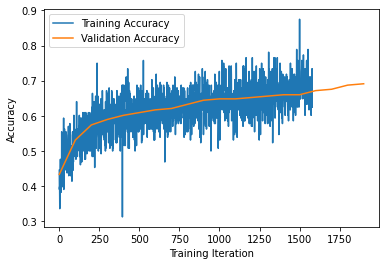

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()